# 0.0. Imports

In [1]:
# pip install pandas numpy sklearn yellowbrick

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m

from yellowbrick.cluster import SilhouetteVisualizer



## 0.1. Helper Functions

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

def change_date(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    return data[column]

def descrever(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.median)).T

    min_ = pd.DataFrame(num_attributes.apply(np.min)).T
    max_ = pd.DataFrame(num_attributes.apply(np.max)).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T
    range_ =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis  = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    unique  = pd.DataFrame(num_attributes.apply(lambda x: x.nunique())).T


    metricas = pd.concat([ min_, max_, range_, mean, median, std, skew, kurtosis, unique]).T
    metricas.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'unique']
    return metricas

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)

## 0.2. Load original datasets

In [3]:
df_geral = pd.read_csv('../data/portfolio_geral.csv', encoding='UTF-8')
df_cliente = pd.read_csv('../data/portfolio_clientes.csv', encoding='UTF-8')
df_comunicados = pd.read_csv('../data/portfolio_comunicados.csv', encoding='UTF-8')
df_tpv = pd.read_csv('../data/portfolio_tpv.csv', encoding='UTF-8')


# 1.0. Mudança de tipos

In [4]:
#mudança de tipos

#dates
dates = ['dt_contrato', 'dt_desembolso','dt_vencimento', 'dt_wo', 'dt_ref_portfolio' ]
for date in dates:
    df_geral[date] = change_date(df_geral, date)

df_comunicados['data_acao'] = change_date(df_comunicados, 'data_acao')
df_comunicados['dt_ref_portfolio'] = change_date(df_comunicados, 'dt_ref_portfolio')

df_tpv['dt_transacao'] = pd.to_datetime(df_tpv['dt_transacao'], format='%Y%m%d')




# 2.0. Tratamentos e Joins

## 2.1. Split portfolio geral

In [5]:
#split geral -> geral e contrato
df_contrato = df_geral[['contrato_id', 'nr_documento', 'safra', 'dt_contrato', 'dt_desembolso',
                        'dt_vencimento','dt_wo', 'prazo', 'vlr_desembolsado',
                        'vlr_tarifa', 'juros_mes','juros_diario']].drop_duplicates('contrato_id')

df_geral = df_geral.drop(['safra', 'dt_contrato', 'dt_desembolso',
                        'dt_vencimento','dt_wo', 'prazo', 'vlr_desembolsado',
                        'vlr_tarifa', 'juros_mes','juros_diario'], axis=1)

## 2.2. Filtrar linhas do df_geral

In [6]:
#filtrar geral -> manter somente primeira linha de settled

#sort df_geral por id e date
df_geral = df_geral.sort_values(['contrato_id', 'dt_ref_portfolio']).reset_index(drop=True)

#pega todas linhas com status quitado
aux = df_geral[df_geral['status_contrato']=='Settled']

#pega data minima de cada contrato quitado
aux0 = aux[['contrato_id', 'dt_ref_portfolio']].groupby('contrato_id').min().reset_index()

#juntar outras features 
aux0 = pd.merge(aux0, df_geral, on=['contrato_id', 'dt_ref_portfolio'], how='inner')

#remover todos status quitados de df_geral
df_geral = df_geral[df_geral['status_contrato']!='Settled']

#colocar de volta apenas o primeiro registro do contrato quitado
df_geral = pd.concat([df_geral, aux0])



In [7]:
#filtrar geral -> manter somente primeira linha de suspended

#sort df_geral por id e date
df_geral = df_geral.sort_values(['contrato_id', 'dt_ref_portfolio']).reset_index(drop=True)

#pega todas linhas com status quitado
aux = df_geral[df_geral['status_contrato']=='Suspended']

#pega data minima de cada contrato quitado
aux0 = aux[['contrato_id', 'dt_ref_portfolio']].groupby('contrato_id').min().reset_index()

#juntar outras features 
aux0 = pd.merge(aux0, df_geral, on=['contrato_id', 'dt_ref_portfolio'], how='inner')

#remover todos status quitados de df_geral
df_geral = df_geral[df_geral['status_contrato']!='Suspended']

#colocar de volta apenas o primeiro registro do contrato quitado
df_geral = pd.concat([df_geral, aux0])

In [8]:
#encontrar dados estranhos
descrever(df_geral)

,min,max,range,mean,median,std,skew,kurtosis,unique
perc_retencao,0.0114,1.20,1.1886,0.205198,0.15348,0.239893,3.471902,11.503958,2301.0
vlr_pgto_realizado,-3055.8700,193253.97,196309.8400,87.671866,0.00000,416.743386,112.540168,30872.474013,110740.0
vlr_pgto_esperado,0.5700,1134.03,1133.4600,111.678561,70.42000,123.989834,2.596089,8.678095,12604.0
vlr_saldo_devedor,-44613.3700,750102.75,794716.1200,29185.548814,15208.86000,41045.879773,3.673719,21.263914,2830341.0
vlr_saldo_devedor_esperado,0.0000,401338.69,401338.6900,20067.744396,9467.91500,30593.651899,3.428292,16.354423,2919488.0
dsp,0.0000,791.00,791.0000,21.718968,1.00000,63.633318,4.437407,24.358919,792.0
dspp,0.0000,833.00,833.0000,56.911421,2.00000,111.969255,2.539394,6.703057,834.0
flag_transacao,0.0000,1.00,1.0000,0.575822,1.00000,0.494218,-0.306836,-1.905853,2.0


In [9]:
#limpar dados estranhos

# vlr_pgto_realizado<0
linhas = len(df_geral[df_geral['vlr_pgto_realizado']<0])
print(f'Linhas removidas para valores de pagamento negativo: {linhas}')
df_geral = df_geral[df_geral['vlr_pgto_realizado']>=0]

# vlr_saldo_devedor <0
linhas = len(df_geral[df_geral['vlr_saldo_devedor']<0])
print(f'Linhas removidas para valores de pagamento negativo: {linhas}')
df_geral = df_geral[df_geral['vlr_saldo_devedor']>=0]


# df_geral[df_geral['vlr_saldo_devedor']<0]

Linhas removidas para valores de pagamento negativo: 14
Linhas removidas para valores de pagamento negativo: 1500


## 2.3. Join -  portifólio geral e de comunicados

In [10]:
#merge geral e comunicados
df_geral_comunicado = pd.merge(df_geral, df_comunicados, on=['contrato_id', 'dt_ref_portfolio'], how='left')


## 2.4. Join - portfólio geral e de tpv

In [11]:
#encontrar dados estranhos tpv
descrever(df_tpv)

,min,max,range,mean,median,std,skew,kurtosis,unique
qtd_transacoes,-2.0,1245.00,1247.00,15.906579,7.0,26.153359,6.003932,70.753434,705.0
vlr_tpv,-125000.0,176880.93,301880.93,887.497885,430.0,1664.209969,10.497490,362.253612,492049.0


In [12]:
#limpar dados estranhos
linhas = len(df_tpv[df_tpv['qtd_transacoes']<0])
print(f'Linhas removidas para valores de quantidade de transação negativo: {linhas}')
df_tpv = df_tpv[df_tpv['qtd_transacoes']>=0]

linhas = len(df_tpv[df_tpv['vlr_tpv']<0])
print(f'Linhas removidas para valores de transação de transação negativo: {linhas}')
df_tpv = df_tpv[df_tpv['vlr_tpv']>=0]


Linhas removidas para valores de quantidade de transação negativo: 7
Linhas removidas para valores de transação de transação negativo: 1238


In [13]:
#merge geral e tpv
df_geral = pd.merge(df_geral, df_tpv.rename(columns = {'dt_transacao':'dt_ref_portfolio'}), on=['nr_documento', 'dt_ref_portfolio'], how='left')
df_geral = df_geral.fillna(0)

## 2.5. Join - df_contrato e portfólio de clientes


In [14]:
#merge contratos e clientes
df_contrato = pd.merge(df_contrato, df_cliente, on='nr_documento', how='inner')

# 3.0. Feature Engineering

### 3.1. Features em df_geral

In [15]:
#valor debitado desconsiderando pagamento 
df_geral['debito_sem_pagamento'] = df_geral['vlr_saldo_devedor'] + df_geral['vlr_pgto_realizado']


#valor pago tpv = valor * perc_retencao/100
df_geral['valor_pago_tpv'] = df_geral['vlr_tpv'] * df_geral['perc_retencao']/100


### 3.2. Features em df_contrato

In [16]:
#extrair ultima data de cada contrato
last_date = df_geral[['contrato_id', 'dt_ref_portfolio']].groupby('contrato_id').max().reset_index()
last_date = pd.merge(last_date, df_geral[['contrato_id', 'dt_ref_portfolio','status_contrato']], on=['contrato_id', 'dt_ref_portfolio'], how='inner')

#conseguir o ultimo status de contrato e ultima data
df_contrato = pd.merge(df_contrato, last_date, on='contrato_id', how='inner').rename(columns={'dt_ref_portfolio':'ultima_data'})

#mean dsp / contrato
aux = df_geral[['dsp', 'contrato_id']].groupby('contrato_id').mean().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#mean dspp / contrato
aux = df_geral[['dspp', 'contrato_id']].groupby('contrato_id').mean().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#sum vlr pago realizado / contrato
aux = df_geral[['vlr_pgto_realizado', 'contrato_id']].groupby('contrato_id').sum().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#sum vlr pago tpv realizado / contrato
aux = df_geral[['valor_pago_tpv', 'contrato_id']].groupby('contrato_id').sum().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#valor total pago / contrato
df_contrato['valor_total_pago'] = df_contrato['vlr_pgto_realizado'] + df_contrato['valor_pago_tpv']

#valor final que deveria ser pago desconsiderando pagamento
aux = df_geral[['debito_sem_pagamento','contrato_id']].groupby('contrato_id').max().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#dias esperado de contrato
df_contrato['tempo_esperado'] = (df_contrato['dt_vencimento'] - df_contrato['dt_desembolso']).dt.days

#dias efetivos de contrato 
aux = df_geral[['contrato_id', 'dt_ref_portfolio']].groupby('contrato_id').count().rename(columns={'dt_ref_portfolio': 'dias_de_contrato'}).reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

#acoes totais
aux = df_geral_comunicado[['contrato_id', 'status']].groupby('contrato_id').count().reset_index().rename(columns={'status': 'n_acoes_total'})
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='inner')

#acoes entregues
aux = df_geral_comunicado [df_geral_comunicado['status']!='NAO ENTREGUE'] [['contrato_id', 'status']].groupby('contrato_id').count().reset_index().rename(columns={'status': 'n_acoes_entregues'})
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='inner')


In [17]:
#check duplicates

#pegando um exemplo para analisar
index = df_contrato[df_contrato['contrato_id'].duplicated()==True].index[1]
id_ = df_contrato.iloc[192,0]
df_contrato[df_contrato['contrato_id']==id_]

,contrato_id,nr_documento,safra,dt_contrato,dt_desembolso,dt_vencimento,dt_wo,prazo,vlr_desembolsado,vlr_tarifa,juros_mes,juros_diario,tipo_empresa,cidade,estado,subsegmento,segmento,ultima_data,status_contrato,dsp,dspp,vlr_pgto_realizado,valor_pago_tpv,valor_total_pago,debito_sem_pagamento,tempo_esperado,dias_de_contrato,n_acoes_total,n_acoes_entregues
191,712b52a60e6e423d1540d197da718844,3316a7fc9281319e4d756a437c36bb9a,2021-01,2021-01-23,2021-01-26,2022-04-23,2023-04-23,25.65,14837.67,0.0,0.04788,0.00157,PJ,Rio de Janeiro,RJ,Outros,Bens duráveis,2022-04-18,Active,33.071588,46.503356,10842.47,51.13206,10893.60206,14931.82,452,447,26,9
192,712b52a60e6e423d1540d197da718844,3316a7fc9281319e4d756a437c36bb9a,2021-01,2021-01-23,2021-01-26,2022-04-23,2023-04-23,25.65,14837.67,0.0,0.04788,0.00157,PF,Rio de Janeiro,RJ,Lojas Diversas,Varejo,2022-04-18,Active,33.071588,46.503356,10842.47,51.13206,10893.60206,14931.82,452,447,26,9


A diferença está no tipo de empresa, subsegmento, segmento

In [18]:
#check numero de duplicados
duplicados = sum(df_contrato['contrato_id'].duplicated()==True)
print(f'Número de duplicados {duplicados}\n')

print('Em relação ao total: {:.3f}%'.format(duplicados/len(df_contrato)*100))

Número de duplicados 144

Em relação ao total: 0.966%


Não haverá grande perda de informação, portanto, os duplicados serão removidos.

In [19]:
#remove duplicates
df_contrato = df_contrato.drop_duplicates('contrato_id')

In [20]:
df_geral.select_dtypes('object').describe()

,contrato_id,nr_documento,status_contrato
count,5661438,5661438,5661438
unique,14756,14265,6
top,561beb8737212f5336cd38333bf5ff3d,ea8ec2f7c6eade8636a0cb2879ab1ecf,Active
freq,832,1359,5641888


# 4.0. Criação de tabelas

## 4.1. Criação da df_mensagem

Um dataframe chamado df_mensagem foi criado apenas com as linhas do df_geral que continha uma comunicação com status diferente de “NAO ENTREGUE” e os 5 registros seguintes. O objetivo desse dataframe é observar o efeito da comunicação nos 5 dias seguintes, através do dsp e dspp. Dessa vez o enfoque é descobrir a curva ideal de vezes que se deve acionar o cliente.


In [21]:
#pegar linha da ação
df_sorted = df_geral_comunicado.sort_values(['contrato_id', 'dt_ref_portfolio']).reset_index(drop=True)

#get index of not null messages
index_mensagem = df_sorted.loc[~df_sorted['status'].isna(), :].index

index_mensagem_expanded = index_mensagem
#create index list expanded

index_aux = index_mensagem + 1
index_mensagem_expanded = index_mensagem_expanded.append(index_aux)
index_aux+=1
index_mensagem_expanded = index_mensagem_expanded.append(index_aux)
index_aux+=1
index_mensagem_expanded = index_mensagem_expanded.append(index_aux)
index_aux+=1
index_mensagem_expanded = index_mensagem_expanded.append(index_aux)
index_aux+=1
index_mensagem_expanded = index_mensagem_expanded.append(index_aux)

#get df mensagem
df_mensagem = df_sorted.iloc[index_mensagem_expanded, :].sort_values(['contrato_id', 'dt_ref_portfolio']).drop_duplicates().reset_index(drop=True)


In [22]:
#especificar ações

df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dsp']==15) , 'acao'] = 'campanhaboletoquitado15'
df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dsp']==90) , 'acao'] = 'campanhaboletoquitado90'
df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dspp']==45) , 'acao'] = 'campanhaboletoquitado45'
df_mensagem.loc[(df_mensagem['acao']=='campanhaobservacao') & (df_mensagem['dsp']==5) , 'acao'] = 'campanhaobservacao05'
df_mensagem.loc[(df_mensagem['acao']=='campanhaobservacao') & (df_mensagem['dspp']==15) , 'acao'] = 'campanhaobservacao15'
df_mensagem.loc[(df_mensagem['acao']=='campanhaparcelamento') & (df_mensagem['dsp']==10) , 'acao'] = 'campanhaparcelamento10'
df_mensagem.loc[(df_mensagem['acao']=='campanhaparcelamento') & (df_mensagem['dspp']==30) , 'acao'] = 'campanhaparcelamento30'

#dia

df_mensagem['dia'] = df_mensagem['acao'].apply(lambda x: 5 if x=='campanhaobservacao05' else 
                                                         10 if (x=='campanhaparcelamento10') else
                                                        15 if (x=='campanhaboletoquitado15') or (x=='campanhaobservacao15') else
                                                        30 if (x=='campanhaparcelamento30') or (x=='campanhaprenegativacao') else
                                                        45 if x=='campanhaboletoquitado45' else
                                                        60 if x=='campanhanegativacao' else 90
                                                          )


df_mensagem['regua'] = df_mensagem['acao'].apply(lambda x: 'dspp' if (x=='campanhaboletoquitado45') or (x=='campanhaparcelamento30') or (x=='campanhaobservacao15') else 'dsp')


In [23]:
#reguas
dsp = ['campanhaobservacao05',
     'campanhaparcelamento10',
 'campanhaboletoquitado15',
 'campanhaprenegativacao',
 'campanhanegativacao',
 'campanhaboletoquitado90'
]

dspp = [
 'campanhaobservacao15',
 'campanhaparcelamento30',
 'campanhaboletoquitado45',
]

In [24]:
#create eficiencia

#get index das mensagens lidas
index_mensagem = df_mensagem.loc[df_mensagem['status'].isin(['LIDO', 'RESPONDIDO']), :].index

for index, i in enumerate(index_mensagem):
    print(f'{index}/{len(index_mensagem)}')
    
    if df_mensagem.loc[i,'status']: #se status existe
            
            
        if df_mensagem['acao'].isin(dsp)[i]: #se a acao for de régua dsp
                
            for i2 in range(i, i+6): #passa pelo próprio dia e os 2 seguintes
                        if df_mensagem.loc[i2, 'dsp']==0:
                            df_mensagem.loc[i,'eficiencia']=1
        else:  #se a acao for de régua dspp
                
                
            for i2 in range(i, i+6): #passa pelo próprio dia e os 2 seguintes
                    if df_mensagem.loc[i2, 'dspp']==0:
                        df_mensagem.loc[i,'eficiencia']=1       

#preencher valores nulos de eficiencia em mensagens lidas com 0
df_mensagem['eficiencia'] = df_mensagem[df_mensagem['status'].isin(['LIDO','RESPONDIDO'])]['eficiencia'].fillna(0)

df_mensagem = df_mensagem[~df_mensagem['status'].isna()]

0/66885
1/66885
2/66885
3/66885
4/66885
5/66885
6/66885
7/66885
8/66885
9/66885
10/66885
11/66885
12/66885
13/66885
14/66885
15/66885
16/66885
17/66885
18/66885
19/66885
20/66885
21/66885
22/66885
23/66885
24/66885
25/66885
26/66885
27/66885
28/66885
29/66885
30/66885
31/66885
32/66885
33/66885
34/66885
35/66885
36/66885
37/66885
38/66885
39/66885
40/66885
41/66885
42/66885
43/66885
44/66885
45/66885
46/66885
47/66885
48/66885
49/66885
50/66885
51/66885
52/66885
53/66885
54/66885
55/66885
56/66885
57/66885
58/66885
59/66885
60/66885
61/66885
62/66885
63/66885
64/66885
65/66885
66/66885
67/66885
68/66885
69/66885
70/66885
71/66885
72/66885
73/66885
74/66885
75/66885
76/66885
77/66885
78/66885
79/66885
80/66885
81/66885
82/66885
83/66885
84/66885
85/66885
86/66885
87/66885
88/66885
89/66885
90/66885
91/66885
92/66885
93/66885
94/66885
95/66885
96/66885
97/66885
98/66885
99/66885
100/66885
101/66885
102/66885
103/66885
104/66885
105/66885
106/66885
107/66885
108/66885
109/66885
110/66885


834/66885
835/66885
836/66885
837/66885
838/66885
839/66885
840/66885
841/66885
842/66885
843/66885
844/66885
845/66885
846/66885
847/66885
848/66885
849/66885
850/66885
851/66885
852/66885
853/66885
854/66885
855/66885
856/66885
857/66885
858/66885
859/66885
860/66885
861/66885
862/66885
863/66885
864/66885
865/66885
866/66885
867/66885
868/66885
869/66885
870/66885
871/66885
872/66885
873/66885
874/66885
875/66885
876/66885
877/66885
878/66885
879/66885
880/66885
881/66885
882/66885
883/66885
884/66885
885/66885
886/66885
887/66885
888/66885
889/66885
890/66885
891/66885
892/66885
893/66885
894/66885
895/66885
896/66885
897/66885
898/66885
899/66885
900/66885
901/66885
902/66885
903/66885
904/66885
905/66885
906/66885
907/66885
908/66885
909/66885
910/66885
911/66885
912/66885
913/66885
914/66885
915/66885
916/66885
917/66885
918/66885
919/66885
920/66885
921/66885
922/66885
923/66885
924/66885
925/66885
926/66885
927/66885
928/66885
929/66885
930/66885
931/66885
932/66885
933/66885


1598/66885
1599/66885
1600/66885
1601/66885
1602/66885
1603/66885
1604/66885
1605/66885
1606/66885
1607/66885
1608/66885
1609/66885
1610/66885
1611/66885
1612/66885
1613/66885
1614/66885
1615/66885
1616/66885
1617/66885
1618/66885
1619/66885
1620/66885
1621/66885
1622/66885
1623/66885
1624/66885
1625/66885
1626/66885
1627/66885
1628/66885
1629/66885
1630/66885
1631/66885
1632/66885
1633/66885
1634/66885
1635/66885
1636/66885
1637/66885
1638/66885
1639/66885
1640/66885
1641/66885
1642/66885
1643/66885
1644/66885
1645/66885
1646/66885
1647/66885
1648/66885
1649/66885
1650/66885
1651/66885
1652/66885
1653/66885
1654/66885
1655/66885
1656/66885
1657/66885
1658/66885
1659/66885
1660/66885
1661/66885
1662/66885
1663/66885
1664/66885
1665/66885
1666/66885
1667/66885
1668/66885
1669/66885
1670/66885
1671/66885
1672/66885
1673/66885
1674/66885
1675/66885
1676/66885
1677/66885
1678/66885
1679/66885
1680/66885
1681/66885
1682/66885
1683/66885
1684/66885
1685/66885
1686/66885
1687/66885
1688/66885

2349/66885
2350/66885
2351/66885
2352/66885
2353/66885
2354/66885
2355/66885
2356/66885
2357/66885
2358/66885
2359/66885
2360/66885
2361/66885
2362/66885
2363/66885
2364/66885
2365/66885
2366/66885
2367/66885
2368/66885
2369/66885
2370/66885
2371/66885
2372/66885
2373/66885
2374/66885
2375/66885
2376/66885
2377/66885
2378/66885
2379/66885
2380/66885
2381/66885
2382/66885
2383/66885
2384/66885
2385/66885
2386/66885
2387/66885
2388/66885
2389/66885
2390/66885
2391/66885
2392/66885
2393/66885
2394/66885
2395/66885
2396/66885
2397/66885
2398/66885
2399/66885
2400/66885
2401/66885
2402/66885
2403/66885
2404/66885
2405/66885
2406/66885
2407/66885
2408/66885
2409/66885
2410/66885
2411/66885
2412/66885
2413/66885
2414/66885
2415/66885
2416/66885
2417/66885
2418/66885
2419/66885
2420/66885
2421/66885
2422/66885
2423/66885
2424/66885
2425/66885
2426/66885
2427/66885
2428/66885
2429/66885
2430/66885
2431/66885
2432/66885
2433/66885
2434/66885
2435/66885
2436/66885
2437/66885
2438/66885
2439/66885

3098/66885
3099/66885
3100/66885
3101/66885
3102/66885
3103/66885
3104/66885
3105/66885
3106/66885
3107/66885
3108/66885
3109/66885
3110/66885
3111/66885
3112/66885
3113/66885
3114/66885
3115/66885
3116/66885
3117/66885
3118/66885
3119/66885
3120/66885
3121/66885
3122/66885
3123/66885
3124/66885
3125/66885
3126/66885
3127/66885
3128/66885
3129/66885
3130/66885
3131/66885
3132/66885
3133/66885
3134/66885
3135/66885
3136/66885
3137/66885
3138/66885
3139/66885
3140/66885
3141/66885
3142/66885
3143/66885
3144/66885
3145/66885
3146/66885
3147/66885
3148/66885
3149/66885
3150/66885
3151/66885
3152/66885
3153/66885
3154/66885
3155/66885
3156/66885
3157/66885
3158/66885
3159/66885
3160/66885
3161/66885
3162/66885
3163/66885
3164/66885
3165/66885
3166/66885
3167/66885
3168/66885
3169/66885
3170/66885
3171/66885
3172/66885
3173/66885
3174/66885
3175/66885
3176/66885
3177/66885
3178/66885
3179/66885
3180/66885
3181/66885
3182/66885
3183/66885
3184/66885
3185/66885
3186/66885
3187/66885
3188/66885

3843/66885
3844/66885
3845/66885
3846/66885
3847/66885
3848/66885
3849/66885
3850/66885
3851/66885
3852/66885
3853/66885
3854/66885
3855/66885
3856/66885
3857/66885
3858/66885
3859/66885
3860/66885
3861/66885
3862/66885
3863/66885
3864/66885
3865/66885
3866/66885
3867/66885
3868/66885
3869/66885
3870/66885
3871/66885
3872/66885
3873/66885
3874/66885
3875/66885
3876/66885
3877/66885
3878/66885
3879/66885
3880/66885
3881/66885
3882/66885
3883/66885
3884/66885
3885/66885
3886/66885
3887/66885
3888/66885
3889/66885
3890/66885
3891/66885
3892/66885
3893/66885
3894/66885
3895/66885
3896/66885
3897/66885
3898/66885
3899/66885
3900/66885
3901/66885
3902/66885
3903/66885
3904/66885
3905/66885
3906/66885
3907/66885
3908/66885
3909/66885
3910/66885
3911/66885
3912/66885
3913/66885
3914/66885
3915/66885
3916/66885
3917/66885
3918/66885
3919/66885
3920/66885
3921/66885
3922/66885
3923/66885
3924/66885
3925/66885
3926/66885
3927/66885
3928/66885
3929/66885
3930/66885
3931/66885
3932/66885
3933/66885

4592/66885
4593/66885
4594/66885
4595/66885
4596/66885
4597/66885
4598/66885
4599/66885
4600/66885
4601/66885
4602/66885
4603/66885
4604/66885
4605/66885
4606/66885
4607/66885
4608/66885
4609/66885
4610/66885
4611/66885
4612/66885
4613/66885
4614/66885
4615/66885
4616/66885
4617/66885
4618/66885
4619/66885
4620/66885
4621/66885
4622/66885
4623/66885
4624/66885
4625/66885
4626/66885
4627/66885
4628/66885
4629/66885
4630/66885
4631/66885
4632/66885
4633/66885
4634/66885
4635/66885
4636/66885
4637/66885
4638/66885
4639/66885
4640/66885
4641/66885
4642/66885
4643/66885
4644/66885
4645/66885
4646/66885
4647/66885
4648/66885
4649/66885
4650/66885
4651/66885
4652/66885
4653/66885
4654/66885
4655/66885
4656/66885
4657/66885
4658/66885
4659/66885
4660/66885
4661/66885
4662/66885
4663/66885
4664/66885
4665/66885
4666/66885
4667/66885
4668/66885
4669/66885
4670/66885
4671/66885
4672/66885
4673/66885
4674/66885
4675/66885
4676/66885
4677/66885
4678/66885
4679/66885
4680/66885
4681/66885
4682/66885

5337/66885
5338/66885
5339/66885
5340/66885
5341/66885
5342/66885
5343/66885
5344/66885
5345/66885
5346/66885
5347/66885
5348/66885
5349/66885
5350/66885
5351/66885
5352/66885
5353/66885
5354/66885
5355/66885
5356/66885
5357/66885
5358/66885
5359/66885
5360/66885
5361/66885
5362/66885
5363/66885
5364/66885
5365/66885
5366/66885
5367/66885
5368/66885
5369/66885
5370/66885
5371/66885
5372/66885
5373/66885
5374/66885
5375/66885
5376/66885
5377/66885
5378/66885
5379/66885
5380/66885
5381/66885
5382/66885
5383/66885
5384/66885
5385/66885
5386/66885
5387/66885
5388/66885
5389/66885
5390/66885
5391/66885
5392/66885
5393/66885
5394/66885
5395/66885
5396/66885
5397/66885
5398/66885
5399/66885
5400/66885
5401/66885
5402/66885
5403/66885
5404/66885
5405/66885
5406/66885
5407/66885
5408/66885
5409/66885
5410/66885
5411/66885
5412/66885
5413/66885
5414/66885
5415/66885
5416/66885
5417/66885
5418/66885
5419/66885
5420/66885
5421/66885
5422/66885
5423/66885
5424/66885
5425/66885
5426/66885
5427/66885

6084/66885
6085/66885
6086/66885
6087/66885
6088/66885
6089/66885
6090/66885
6091/66885
6092/66885
6093/66885
6094/66885
6095/66885
6096/66885
6097/66885
6098/66885
6099/66885
6100/66885
6101/66885
6102/66885
6103/66885
6104/66885
6105/66885
6106/66885
6107/66885
6108/66885
6109/66885
6110/66885
6111/66885
6112/66885
6113/66885
6114/66885
6115/66885
6116/66885
6117/66885
6118/66885
6119/66885
6120/66885
6121/66885
6122/66885
6123/66885
6124/66885
6125/66885
6126/66885
6127/66885
6128/66885
6129/66885
6130/66885
6131/66885
6132/66885
6133/66885
6134/66885
6135/66885
6136/66885
6137/66885
6138/66885
6139/66885
6140/66885
6141/66885
6142/66885
6143/66885
6144/66885
6145/66885
6146/66885
6147/66885
6148/66885
6149/66885
6150/66885
6151/66885
6152/66885
6153/66885
6154/66885
6155/66885
6156/66885
6157/66885
6158/66885
6159/66885
6160/66885
6161/66885
6162/66885
6163/66885
6164/66885
6165/66885
6166/66885
6167/66885
6168/66885
6169/66885
6170/66885
6171/66885
6172/66885
6173/66885
6174/66885

6833/66885
6834/66885
6835/66885
6836/66885
6837/66885
6838/66885
6839/66885
6840/66885
6841/66885
6842/66885
6843/66885
6844/66885
6845/66885
6846/66885
6847/66885
6848/66885
6849/66885
6850/66885
6851/66885
6852/66885
6853/66885
6854/66885
6855/66885
6856/66885
6857/66885
6858/66885
6859/66885
6860/66885
6861/66885
6862/66885
6863/66885
6864/66885
6865/66885
6866/66885
6867/66885
6868/66885
6869/66885
6870/66885
6871/66885
6872/66885
6873/66885
6874/66885
6875/66885
6876/66885
6877/66885
6878/66885
6879/66885
6880/66885
6881/66885
6882/66885
6883/66885
6884/66885
6885/66885
6886/66885
6887/66885
6888/66885
6889/66885
6890/66885
6891/66885
6892/66885
6893/66885
6894/66885
6895/66885
6896/66885
6897/66885
6898/66885
6899/66885
6900/66885
6901/66885
6902/66885
6903/66885
6904/66885
6905/66885
6906/66885
6907/66885
6908/66885
6909/66885
6910/66885
6911/66885
6912/66885
6913/66885
6914/66885
6915/66885
6916/66885
6917/66885
6918/66885
6919/66885
6920/66885
6921/66885
6922/66885
6923/66885

7578/66885
7579/66885
7580/66885
7581/66885
7582/66885
7583/66885
7584/66885
7585/66885
7586/66885
7587/66885
7588/66885
7589/66885
7590/66885
7591/66885
7592/66885
7593/66885
7594/66885
7595/66885
7596/66885
7597/66885
7598/66885
7599/66885
7600/66885
7601/66885
7602/66885
7603/66885
7604/66885
7605/66885
7606/66885
7607/66885
7608/66885
7609/66885
7610/66885
7611/66885
7612/66885
7613/66885
7614/66885
7615/66885
7616/66885
7617/66885
7618/66885
7619/66885
7620/66885
7621/66885
7622/66885
7623/66885
7624/66885
7625/66885
7626/66885
7627/66885
7628/66885
7629/66885
7630/66885
7631/66885
7632/66885
7633/66885
7634/66885
7635/66885
7636/66885
7637/66885
7638/66885
7639/66885
7640/66885
7641/66885
7642/66885
7643/66885
7644/66885
7645/66885
7646/66885
7647/66885
7648/66885
7649/66885
7650/66885
7651/66885
7652/66885
7653/66885
7654/66885
7655/66885
7656/66885
7657/66885
7658/66885
7659/66885
7660/66885
7661/66885
7662/66885
7663/66885
7664/66885
7665/66885
7666/66885
7667/66885
7668/66885

8328/66885
8329/66885
8330/66885
8331/66885
8332/66885
8333/66885
8334/66885
8335/66885
8336/66885
8337/66885
8338/66885
8339/66885
8340/66885
8341/66885
8342/66885
8343/66885
8344/66885
8345/66885
8346/66885
8347/66885
8348/66885
8349/66885
8350/66885
8351/66885
8352/66885
8353/66885
8354/66885
8355/66885
8356/66885
8357/66885
8358/66885
8359/66885
8360/66885
8361/66885
8362/66885
8363/66885
8364/66885
8365/66885
8366/66885
8367/66885
8368/66885
8369/66885
8370/66885
8371/66885
8372/66885
8373/66885
8374/66885
8375/66885
8376/66885
8377/66885
8378/66885
8379/66885
8380/66885
8381/66885
8382/66885
8383/66885
8384/66885
8385/66885
8386/66885
8387/66885
8388/66885
8389/66885
8390/66885
8391/66885
8392/66885
8393/66885
8394/66885
8395/66885
8396/66885
8397/66885
8398/66885
8399/66885
8400/66885
8401/66885
8402/66885
8403/66885
8404/66885
8405/66885
8406/66885
8407/66885
8408/66885
8409/66885
8410/66885
8411/66885
8412/66885
8413/66885
8414/66885
8415/66885
8416/66885
8417/66885
8418/66885

9076/66885
9077/66885
9078/66885
9079/66885
9080/66885
9081/66885
9082/66885
9083/66885
9084/66885
9085/66885
9086/66885
9087/66885
9088/66885
9089/66885
9090/66885
9091/66885
9092/66885
9093/66885
9094/66885
9095/66885
9096/66885
9097/66885
9098/66885
9099/66885
9100/66885
9101/66885
9102/66885
9103/66885
9104/66885
9105/66885
9106/66885
9107/66885
9108/66885
9109/66885
9110/66885
9111/66885
9112/66885
9113/66885
9114/66885
9115/66885
9116/66885
9117/66885
9118/66885
9119/66885
9120/66885
9121/66885
9122/66885
9123/66885
9124/66885
9125/66885
9126/66885
9127/66885
9128/66885
9129/66885
9130/66885
9131/66885
9132/66885
9133/66885
9134/66885
9135/66885
9136/66885
9137/66885
9138/66885
9139/66885
9140/66885
9141/66885
9142/66885
9143/66885
9144/66885
9145/66885
9146/66885
9147/66885
9148/66885
9149/66885
9150/66885
9151/66885
9152/66885
9153/66885
9154/66885
9155/66885
9156/66885
9157/66885
9158/66885
9159/66885
9160/66885
9161/66885
9162/66885
9163/66885
9164/66885
9165/66885
9166/66885

9828/66885
9829/66885
9830/66885
9831/66885
9832/66885
9833/66885
9834/66885
9835/66885
9836/66885
9837/66885
9838/66885
9839/66885
9840/66885
9841/66885
9842/66885
9843/66885
9844/66885
9845/66885
9846/66885
9847/66885
9848/66885
9849/66885
9850/66885
9851/66885
9852/66885
9853/66885
9854/66885
9855/66885
9856/66885
9857/66885
9858/66885
9859/66885
9860/66885
9861/66885
9862/66885
9863/66885
9864/66885
9865/66885
9866/66885
9867/66885
9868/66885
9869/66885
9870/66885
9871/66885
9872/66885
9873/66885
9874/66885
9875/66885
9876/66885
9877/66885
9878/66885
9879/66885
9880/66885
9881/66885
9882/66885
9883/66885
9884/66885
9885/66885
9886/66885
9887/66885
9888/66885
9889/66885
9890/66885
9891/66885
9892/66885
9893/66885
9894/66885
9895/66885
9896/66885
9897/66885
9898/66885
9899/66885
9900/66885
9901/66885
9902/66885
9903/66885
9904/66885
9905/66885
9906/66885
9907/66885
9908/66885
9909/66885
9910/66885
9911/66885
9912/66885
9913/66885
9914/66885
9915/66885
9916/66885
9917/66885
9918/66885

10526/66885
10527/66885
10528/66885
10529/66885
10530/66885
10531/66885
10532/66885
10533/66885
10534/66885
10535/66885
10536/66885
10537/66885
10538/66885
10539/66885
10540/66885
10541/66885
10542/66885
10543/66885
10544/66885
10545/66885
10546/66885
10547/66885
10548/66885
10549/66885
10550/66885
10551/66885
10552/66885
10553/66885
10554/66885
10555/66885
10556/66885
10557/66885
10558/66885
10559/66885
10560/66885
10561/66885
10562/66885
10563/66885
10564/66885
10565/66885
10566/66885
10567/66885
10568/66885
10569/66885
10570/66885
10571/66885
10572/66885
10573/66885
10574/66885
10575/66885
10576/66885
10577/66885
10578/66885
10579/66885
10580/66885
10581/66885
10582/66885
10583/66885
10584/66885
10585/66885
10586/66885
10587/66885
10588/66885
10589/66885
10590/66885
10591/66885
10592/66885
10593/66885
10594/66885
10595/66885
10596/66885
10597/66885
10598/66885
10599/66885
10600/66885
10601/66885
10602/66885
10603/66885
10604/66885
10605/66885
10606/66885
10607/66885
10608/66885
1060

11210/66885
11211/66885
11212/66885
11213/66885
11214/66885
11215/66885
11216/66885
11217/66885
11218/66885
11219/66885
11220/66885
11221/66885
11222/66885
11223/66885
11224/66885
11225/66885
11226/66885
11227/66885
11228/66885
11229/66885
11230/66885
11231/66885
11232/66885
11233/66885
11234/66885
11235/66885
11236/66885
11237/66885
11238/66885
11239/66885
11240/66885
11241/66885
11242/66885
11243/66885
11244/66885
11245/66885
11246/66885
11247/66885
11248/66885
11249/66885
11250/66885
11251/66885
11252/66885
11253/66885
11254/66885
11255/66885
11256/66885
11257/66885
11258/66885
11259/66885
11260/66885
11261/66885
11262/66885
11263/66885
11264/66885
11265/66885
11266/66885
11267/66885
11268/66885
11269/66885
11270/66885
11271/66885
11272/66885
11273/66885
11274/66885
11275/66885
11276/66885
11277/66885
11278/66885
11279/66885
11280/66885
11281/66885
11282/66885
11283/66885
11284/66885
11285/66885
11286/66885
11287/66885
11288/66885
11289/66885
11290/66885
11291/66885
11292/66885
1129

11900/66885
11901/66885
11902/66885
11903/66885
11904/66885
11905/66885
11906/66885
11907/66885
11908/66885
11909/66885
11910/66885
11911/66885
11912/66885
11913/66885
11914/66885
11915/66885
11916/66885
11917/66885
11918/66885
11919/66885
11920/66885
11921/66885
11922/66885
11923/66885
11924/66885
11925/66885
11926/66885
11927/66885
11928/66885
11929/66885
11930/66885
11931/66885
11932/66885
11933/66885
11934/66885
11935/66885
11936/66885
11937/66885
11938/66885
11939/66885
11940/66885
11941/66885
11942/66885
11943/66885
11944/66885
11945/66885
11946/66885
11947/66885
11948/66885
11949/66885
11950/66885
11951/66885
11952/66885
11953/66885
11954/66885
11955/66885
11956/66885
11957/66885
11958/66885
11959/66885
11960/66885
11961/66885
11962/66885
11963/66885
11964/66885
11965/66885
11966/66885
11967/66885
11968/66885
11969/66885
11970/66885
11971/66885
11972/66885
11973/66885
11974/66885
11975/66885
11976/66885
11977/66885
11978/66885
11979/66885
11980/66885
11981/66885
11982/66885
1198

12584/66885
12585/66885
12586/66885
12587/66885
12588/66885
12589/66885
12590/66885
12591/66885
12592/66885
12593/66885
12594/66885
12595/66885
12596/66885
12597/66885
12598/66885
12599/66885
12600/66885
12601/66885
12602/66885
12603/66885
12604/66885
12605/66885
12606/66885
12607/66885
12608/66885
12609/66885
12610/66885
12611/66885
12612/66885
12613/66885
12614/66885
12615/66885
12616/66885
12617/66885
12618/66885
12619/66885
12620/66885
12621/66885
12622/66885
12623/66885
12624/66885
12625/66885
12626/66885
12627/66885
12628/66885
12629/66885
12630/66885
12631/66885
12632/66885
12633/66885
12634/66885
12635/66885
12636/66885
12637/66885
12638/66885
12639/66885
12640/66885
12641/66885
12642/66885
12643/66885
12644/66885
12645/66885
12646/66885
12647/66885
12648/66885
12649/66885
12650/66885
12651/66885
12652/66885
12653/66885
12654/66885
12655/66885
12656/66885
12657/66885
12658/66885
12659/66885
12660/66885
12661/66885
12662/66885
12663/66885
12664/66885
12665/66885
12666/66885
1266

13272/66885
13273/66885
13274/66885
13275/66885
13276/66885
13277/66885
13278/66885
13279/66885
13280/66885
13281/66885
13282/66885
13283/66885
13284/66885
13285/66885
13286/66885
13287/66885
13288/66885
13289/66885
13290/66885
13291/66885
13292/66885
13293/66885
13294/66885
13295/66885
13296/66885
13297/66885
13298/66885
13299/66885
13300/66885
13301/66885
13302/66885
13303/66885
13304/66885
13305/66885
13306/66885
13307/66885
13308/66885
13309/66885
13310/66885
13311/66885
13312/66885
13313/66885
13314/66885
13315/66885
13316/66885
13317/66885
13318/66885
13319/66885
13320/66885
13321/66885
13322/66885
13323/66885
13324/66885
13325/66885
13326/66885
13327/66885
13328/66885
13329/66885
13330/66885
13331/66885
13332/66885
13333/66885
13334/66885
13335/66885
13336/66885
13337/66885
13338/66885
13339/66885
13340/66885
13341/66885
13342/66885
13343/66885
13344/66885
13345/66885
13346/66885
13347/66885
13348/66885
13349/66885
13350/66885
13351/66885
13352/66885
13353/66885
13354/66885
1335

13960/66885
13961/66885
13962/66885
13963/66885
13964/66885
13965/66885
13966/66885
13967/66885
13968/66885
13969/66885
13970/66885
13971/66885
13972/66885
13973/66885
13974/66885
13975/66885
13976/66885
13977/66885
13978/66885
13979/66885
13980/66885
13981/66885
13982/66885
13983/66885
13984/66885
13985/66885
13986/66885
13987/66885
13988/66885
13989/66885
13990/66885
13991/66885
13992/66885
13993/66885
13994/66885
13995/66885
13996/66885
13997/66885
13998/66885
13999/66885
14000/66885
14001/66885
14002/66885
14003/66885
14004/66885
14005/66885
14006/66885
14007/66885
14008/66885
14009/66885
14010/66885
14011/66885
14012/66885
14013/66885
14014/66885
14015/66885
14016/66885
14017/66885
14018/66885
14019/66885
14020/66885
14021/66885
14022/66885
14023/66885
14024/66885
14025/66885
14026/66885
14027/66885
14028/66885
14029/66885
14030/66885
14031/66885
14032/66885
14033/66885
14034/66885
14035/66885
14036/66885
14037/66885
14038/66885
14039/66885
14040/66885
14041/66885
14042/66885
1404

14647/66885
14648/66885
14649/66885
14650/66885
14651/66885
14652/66885
14653/66885
14654/66885
14655/66885
14656/66885
14657/66885
14658/66885
14659/66885
14660/66885
14661/66885
14662/66885
14663/66885
14664/66885
14665/66885
14666/66885
14667/66885
14668/66885
14669/66885
14670/66885
14671/66885
14672/66885
14673/66885
14674/66885
14675/66885
14676/66885
14677/66885
14678/66885
14679/66885
14680/66885
14681/66885
14682/66885
14683/66885
14684/66885
14685/66885
14686/66885
14687/66885
14688/66885
14689/66885
14690/66885
14691/66885
14692/66885
14693/66885
14694/66885
14695/66885
14696/66885
14697/66885
14698/66885
14699/66885
14700/66885
14701/66885
14702/66885
14703/66885
14704/66885
14705/66885
14706/66885
14707/66885
14708/66885
14709/66885
14710/66885
14711/66885
14712/66885
14713/66885
14714/66885
14715/66885
14716/66885
14717/66885
14718/66885
14719/66885
14720/66885
14721/66885
14722/66885
14723/66885
14724/66885
14725/66885
14726/66885
14727/66885
14728/66885
14729/66885
1473

15334/66885
15335/66885
15336/66885
15337/66885
15338/66885
15339/66885
15340/66885
15341/66885
15342/66885
15343/66885
15344/66885
15345/66885
15346/66885
15347/66885
15348/66885
15349/66885
15350/66885
15351/66885
15352/66885
15353/66885
15354/66885
15355/66885
15356/66885
15357/66885
15358/66885
15359/66885
15360/66885
15361/66885
15362/66885
15363/66885
15364/66885
15365/66885
15366/66885
15367/66885
15368/66885
15369/66885
15370/66885
15371/66885
15372/66885
15373/66885
15374/66885
15375/66885
15376/66885
15377/66885
15378/66885
15379/66885
15380/66885
15381/66885
15382/66885
15383/66885
15384/66885
15385/66885
15386/66885
15387/66885
15388/66885
15389/66885
15390/66885
15391/66885
15392/66885
15393/66885
15394/66885
15395/66885
15396/66885
15397/66885
15398/66885
15399/66885
15400/66885
15401/66885
15402/66885
15403/66885
15404/66885
15405/66885
15406/66885
15407/66885
15408/66885
15409/66885
15410/66885
15411/66885
15412/66885
15413/66885
15414/66885
15415/66885
15416/66885
1541

16021/66885
16022/66885
16023/66885
16024/66885
16025/66885
16026/66885
16027/66885
16028/66885
16029/66885
16030/66885
16031/66885
16032/66885
16033/66885
16034/66885
16035/66885
16036/66885
16037/66885
16038/66885
16039/66885
16040/66885
16041/66885
16042/66885
16043/66885
16044/66885
16045/66885
16046/66885
16047/66885
16048/66885
16049/66885
16050/66885
16051/66885
16052/66885
16053/66885
16054/66885
16055/66885
16056/66885
16057/66885
16058/66885
16059/66885
16060/66885
16061/66885
16062/66885
16063/66885
16064/66885
16065/66885
16066/66885
16067/66885
16068/66885
16069/66885
16070/66885
16071/66885
16072/66885
16073/66885
16074/66885
16075/66885
16076/66885
16077/66885
16078/66885
16079/66885
16080/66885
16081/66885
16082/66885
16083/66885
16084/66885
16085/66885
16086/66885
16087/66885
16088/66885
16089/66885
16090/66885
16091/66885
16092/66885
16093/66885
16094/66885
16095/66885
16096/66885
16097/66885
16098/66885
16099/66885
16100/66885
16101/66885
16102/66885
16103/66885
1610

16704/66885
16705/66885
16706/66885
16707/66885
16708/66885
16709/66885
16710/66885
16711/66885
16712/66885
16713/66885
16714/66885
16715/66885
16716/66885
16717/66885
16718/66885
16719/66885
16720/66885
16721/66885
16722/66885
16723/66885
16724/66885
16725/66885
16726/66885
16727/66885
16728/66885
16729/66885
16730/66885
16731/66885
16732/66885
16733/66885
16734/66885
16735/66885
16736/66885
16737/66885
16738/66885
16739/66885
16740/66885
16741/66885
16742/66885
16743/66885
16744/66885
16745/66885
16746/66885
16747/66885
16748/66885
16749/66885
16750/66885
16751/66885
16752/66885
16753/66885
16754/66885
16755/66885
16756/66885
16757/66885
16758/66885
16759/66885
16760/66885
16761/66885
16762/66885
16763/66885
16764/66885
16765/66885
16766/66885
16767/66885
16768/66885
16769/66885
16770/66885
16771/66885
16772/66885
16773/66885
16774/66885
16775/66885
16776/66885
16777/66885
16778/66885
16779/66885
16780/66885
16781/66885
16782/66885
16783/66885
16784/66885
16785/66885
16786/66885
1678

17387/66885
17388/66885
17389/66885
17390/66885
17391/66885
17392/66885
17393/66885
17394/66885
17395/66885
17396/66885
17397/66885
17398/66885
17399/66885
17400/66885
17401/66885
17402/66885
17403/66885
17404/66885
17405/66885
17406/66885
17407/66885
17408/66885
17409/66885
17410/66885
17411/66885
17412/66885
17413/66885
17414/66885
17415/66885
17416/66885
17417/66885
17418/66885
17419/66885
17420/66885
17421/66885
17422/66885
17423/66885
17424/66885
17425/66885
17426/66885
17427/66885
17428/66885
17429/66885
17430/66885
17431/66885
17432/66885
17433/66885
17434/66885
17435/66885
17436/66885
17437/66885
17438/66885
17439/66885
17440/66885
17441/66885
17442/66885
17443/66885
17444/66885
17445/66885
17446/66885
17447/66885
17448/66885
17449/66885
17450/66885
17451/66885
17452/66885
17453/66885
17454/66885
17455/66885
17456/66885
17457/66885
17458/66885
17459/66885
17460/66885
17461/66885
17462/66885
17463/66885
17464/66885
17465/66885
17466/66885
17467/66885
17468/66885
17469/66885
1747

18071/66885
18072/66885
18073/66885
18074/66885
18075/66885
18076/66885
18077/66885
18078/66885
18079/66885
18080/66885
18081/66885
18082/66885
18083/66885
18084/66885
18085/66885
18086/66885
18087/66885
18088/66885
18089/66885
18090/66885
18091/66885
18092/66885
18093/66885
18094/66885
18095/66885
18096/66885
18097/66885
18098/66885
18099/66885
18100/66885
18101/66885
18102/66885
18103/66885
18104/66885
18105/66885
18106/66885
18107/66885
18108/66885
18109/66885
18110/66885
18111/66885
18112/66885
18113/66885
18114/66885
18115/66885
18116/66885
18117/66885
18118/66885
18119/66885
18120/66885
18121/66885
18122/66885
18123/66885
18124/66885
18125/66885
18126/66885
18127/66885
18128/66885
18129/66885
18130/66885
18131/66885
18132/66885
18133/66885
18134/66885
18135/66885
18136/66885
18137/66885
18138/66885
18139/66885
18140/66885
18141/66885
18142/66885
18143/66885
18144/66885
18145/66885
18146/66885
18147/66885
18148/66885
18149/66885
18150/66885
18151/66885
18152/66885
18153/66885
1815

18755/66885
18756/66885
18757/66885
18758/66885
18759/66885
18760/66885
18761/66885
18762/66885
18763/66885
18764/66885
18765/66885
18766/66885
18767/66885
18768/66885
18769/66885
18770/66885
18771/66885
18772/66885
18773/66885
18774/66885
18775/66885
18776/66885
18777/66885
18778/66885
18779/66885
18780/66885
18781/66885
18782/66885
18783/66885
18784/66885
18785/66885
18786/66885
18787/66885
18788/66885
18789/66885
18790/66885
18791/66885
18792/66885
18793/66885
18794/66885
18795/66885
18796/66885
18797/66885
18798/66885
18799/66885
18800/66885
18801/66885
18802/66885
18803/66885
18804/66885
18805/66885
18806/66885
18807/66885
18808/66885
18809/66885
18810/66885
18811/66885
18812/66885
18813/66885
18814/66885
18815/66885
18816/66885
18817/66885
18818/66885
18819/66885
18820/66885
18821/66885
18822/66885
18823/66885
18824/66885
18825/66885
18826/66885
18827/66885
18828/66885
18829/66885
18830/66885
18831/66885
18832/66885
18833/66885
18834/66885
18835/66885
18836/66885
18837/66885
1883

19440/66885
19441/66885
19442/66885
19443/66885
19444/66885
19445/66885
19446/66885
19447/66885
19448/66885
19449/66885
19450/66885
19451/66885
19452/66885
19453/66885
19454/66885
19455/66885
19456/66885
19457/66885
19458/66885
19459/66885
19460/66885
19461/66885
19462/66885
19463/66885
19464/66885
19465/66885
19466/66885
19467/66885
19468/66885
19469/66885
19470/66885
19471/66885
19472/66885
19473/66885
19474/66885
19475/66885
19476/66885
19477/66885
19478/66885
19479/66885
19480/66885
19481/66885
19482/66885
19483/66885
19484/66885
19485/66885
19486/66885
19487/66885
19488/66885
19489/66885
19490/66885
19491/66885
19492/66885
19493/66885
19494/66885
19495/66885
19496/66885
19497/66885
19498/66885
19499/66885
19500/66885
19501/66885
19502/66885
19503/66885
19504/66885
19505/66885
19506/66885
19507/66885
19508/66885
19509/66885
19510/66885
19511/66885
19512/66885
19513/66885
19514/66885
19515/66885
19516/66885
19517/66885
19518/66885
19519/66885
19520/66885
19521/66885
19522/66885
1952

20125/66885
20126/66885
20127/66885
20128/66885
20129/66885
20130/66885
20131/66885
20132/66885
20133/66885
20134/66885
20135/66885
20136/66885
20137/66885
20138/66885
20139/66885
20140/66885
20141/66885
20142/66885
20143/66885
20144/66885
20145/66885
20146/66885
20147/66885
20148/66885
20149/66885
20150/66885
20151/66885
20152/66885
20153/66885
20154/66885
20155/66885
20156/66885
20157/66885
20158/66885
20159/66885
20160/66885
20161/66885
20162/66885
20163/66885
20164/66885
20165/66885
20166/66885
20167/66885
20168/66885
20169/66885
20170/66885
20171/66885
20172/66885
20173/66885
20174/66885
20175/66885
20176/66885
20177/66885
20178/66885
20179/66885
20180/66885
20181/66885
20182/66885
20183/66885
20184/66885
20185/66885
20186/66885
20187/66885
20188/66885
20189/66885
20190/66885
20191/66885
20192/66885
20193/66885
20194/66885
20195/66885
20196/66885
20197/66885
20198/66885
20199/66885
20200/66885
20201/66885
20202/66885
20203/66885
20204/66885
20205/66885
20206/66885
20207/66885
2020

20808/66885
20809/66885
20810/66885
20811/66885
20812/66885
20813/66885
20814/66885
20815/66885
20816/66885
20817/66885
20818/66885
20819/66885
20820/66885
20821/66885
20822/66885
20823/66885
20824/66885
20825/66885
20826/66885
20827/66885
20828/66885
20829/66885
20830/66885
20831/66885
20832/66885
20833/66885
20834/66885
20835/66885
20836/66885
20837/66885
20838/66885
20839/66885
20840/66885
20841/66885
20842/66885
20843/66885
20844/66885
20845/66885
20846/66885
20847/66885
20848/66885
20849/66885
20850/66885
20851/66885
20852/66885
20853/66885
20854/66885
20855/66885
20856/66885
20857/66885
20858/66885
20859/66885
20860/66885
20861/66885
20862/66885
20863/66885
20864/66885
20865/66885
20866/66885
20867/66885
20868/66885
20869/66885
20870/66885
20871/66885
20872/66885
20873/66885
20874/66885
20875/66885
20876/66885
20877/66885
20878/66885
20879/66885
20880/66885
20881/66885
20882/66885
20883/66885
20884/66885
20885/66885
20886/66885
20887/66885
20888/66885
20889/66885
20890/66885
2089

21499/66885
21500/66885
21501/66885
21502/66885
21503/66885
21504/66885
21505/66885
21506/66885
21507/66885
21508/66885
21509/66885
21510/66885
21511/66885
21512/66885
21513/66885
21514/66885
21515/66885
21516/66885
21517/66885
21518/66885
21519/66885
21520/66885
21521/66885
21522/66885
21523/66885
21524/66885
21525/66885
21526/66885
21527/66885
21528/66885
21529/66885
21530/66885
21531/66885
21532/66885
21533/66885
21534/66885
21535/66885
21536/66885
21537/66885
21538/66885
21539/66885
21540/66885
21541/66885
21542/66885
21543/66885
21544/66885
21545/66885
21546/66885
21547/66885
21548/66885
21549/66885
21550/66885
21551/66885
21552/66885
21553/66885
21554/66885
21555/66885
21556/66885
21557/66885
21558/66885
21559/66885
21560/66885
21561/66885
21562/66885
21563/66885
21564/66885
21565/66885
21566/66885
21567/66885
21568/66885
21569/66885
21570/66885
21571/66885
21572/66885
21573/66885
21574/66885
21575/66885
21576/66885
21577/66885
21578/66885
21579/66885
21580/66885
21581/66885
2158

22188/66885
22189/66885
22190/66885
22191/66885
22192/66885
22193/66885
22194/66885
22195/66885
22196/66885
22197/66885
22198/66885
22199/66885
22200/66885
22201/66885
22202/66885
22203/66885
22204/66885
22205/66885
22206/66885
22207/66885
22208/66885
22209/66885
22210/66885
22211/66885
22212/66885
22213/66885
22214/66885
22215/66885
22216/66885
22217/66885
22218/66885
22219/66885
22220/66885
22221/66885
22222/66885
22223/66885
22224/66885
22225/66885
22226/66885
22227/66885
22228/66885
22229/66885
22230/66885
22231/66885
22232/66885
22233/66885
22234/66885
22235/66885
22236/66885
22237/66885
22238/66885
22239/66885
22240/66885
22241/66885
22242/66885
22243/66885
22244/66885
22245/66885
22246/66885
22247/66885
22248/66885
22249/66885
22250/66885
22251/66885
22252/66885
22253/66885
22254/66885
22255/66885
22256/66885
22257/66885
22258/66885
22259/66885
22260/66885
22261/66885
22262/66885
22263/66885
22264/66885
22265/66885
22266/66885
22267/66885
22268/66885
22269/66885
22270/66885
2227

22877/66885
22878/66885
22879/66885
22880/66885
22881/66885
22882/66885
22883/66885
22884/66885
22885/66885
22886/66885
22887/66885
22888/66885
22889/66885
22890/66885
22891/66885
22892/66885
22893/66885
22894/66885
22895/66885
22896/66885
22897/66885
22898/66885
22899/66885
22900/66885
22901/66885
22902/66885
22903/66885
22904/66885
22905/66885
22906/66885
22907/66885
22908/66885
22909/66885
22910/66885
22911/66885
22912/66885
22913/66885
22914/66885
22915/66885
22916/66885
22917/66885
22918/66885
22919/66885
22920/66885
22921/66885
22922/66885
22923/66885
22924/66885
22925/66885
22926/66885
22927/66885
22928/66885
22929/66885
22930/66885
22931/66885
22932/66885
22933/66885
22934/66885
22935/66885
22936/66885
22937/66885
22938/66885
22939/66885
22940/66885
22941/66885
22942/66885
22943/66885
22944/66885
22945/66885
22946/66885
22947/66885
22948/66885
22949/66885
22950/66885
22951/66885
22952/66885
22953/66885
22954/66885
22955/66885
22956/66885
22957/66885
22958/66885
22959/66885
2296

23565/66885
23566/66885
23567/66885
23568/66885
23569/66885
23570/66885
23571/66885
23572/66885
23573/66885
23574/66885
23575/66885
23576/66885
23577/66885
23578/66885
23579/66885
23580/66885
23581/66885
23582/66885
23583/66885
23584/66885
23585/66885
23586/66885
23587/66885
23588/66885
23589/66885
23590/66885
23591/66885
23592/66885
23593/66885
23594/66885
23595/66885
23596/66885
23597/66885
23598/66885
23599/66885
23600/66885
23601/66885
23602/66885
23603/66885
23604/66885
23605/66885
23606/66885
23607/66885
23608/66885
23609/66885
23610/66885
23611/66885
23612/66885
23613/66885
23614/66885
23615/66885
23616/66885
23617/66885
23618/66885
23619/66885
23620/66885
23621/66885
23622/66885
23623/66885
23624/66885
23625/66885
23626/66885
23627/66885
23628/66885
23629/66885
23630/66885
23631/66885
23632/66885
23633/66885
23634/66885
23635/66885
23636/66885
23637/66885
23638/66885
23639/66885
23640/66885
23641/66885
23642/66885
23643/66885
23644/66885
23645/66885
23646/66885
23647/66885
2364

24252/66885
24253/66885
24254/66885
24255/66885
24256/66885
24257/66885
24258/66885
24259/66885
24260/66885
24261/66885
24262/66885
24263/66885
24264/66885
24265/66885
24266/66885
24267/66885
24268/66885
24269/66885
24270/66885
24271/66885
24272/66885
24273/66885
24274/66885
24275/66885
24276/66885
24277/66885
24278/66885
24279/66885
24280/66885
24281/66885
24282/66885
24283/66885
24284/66885
24285/66885
24286/66885
24287/66885
24288/66885
24289/66885
24290/66885
24291/66885
24292/66885
24293/66885
24294/66885
24295/66885
24296/66885
24297/66885
24298/66885
24299/66885
24300/66885
24301/66885
24302/66885
24303/66885
24304/66885
24305/66885
24306/66885
24307/66885
24308/66885
24309/66885
24310/66885
24311/66885
24312/66885
24313/66885
24314/66885
24315/66885
24316/66885
24317/66885
24318/66885
24319/66885
24320/66885
24321/66885
24322/66885
24323/66885
24324/66885
24325/66885
24326/66885
24327/66885
24328/66885
24329/66885
24330/66885
24331/66885
24332/66885
24333/66885
24334/66885
2433

24938/66885
24939/66885
24940/66885
24941/66885
24942/66885
24943/66885
24944/66885
24945/66885
24946/66885
24947/66885
24948/66885
24949/66885
24950/66885
24951/66885
24952/66885
24953/66885
24954/66885
24955/66885
24956/66885
24957/66885
24958/66885
24959/66885
24960/66885
24961/66885
24962/66885
24963/66885
24964/66885
24965/66885
24966/66885
24967/66885
24968/66885
24969/66885
24970/66885
24971/66885
24972/66885
24973/66885
24974/66885
24975/66885
24976/66885
24977/66885
24978/66885
24979/66885
24980/66885
24981/66885
24982/66885
24983/66885
24984/66885
24985/66885
24986/66885
24987/66885
24988/66885
24989/66885
24990/66885
24991/66885
24992/66885
24993/66885
24994/66885
24995/66885
24996/66885
24997/66885
24998/66885
24999/66885
25000/66885
25001/66885
25002/66885
25003/66885
25004/66885
25005/66885
25006/66885
25007/66885
25008/66885
25009/66885
25010/66885
25011/66885
25012/66885
25013/66885
25014/66885
25015/66885
25016/66885
25017/66885
25018/66885
25019/66885
25020/66885
2502

25622/66885
25623/66885
25624/66885
25625/66885
25626/66885
25627/66885
25628/66885
25629/66885
25630/66885
25631/66885
25632/66885
25633/66885
25634/66885
25635/66885
25636/66885
25637/66885
25638/66885
25639/66885
25640/66885
25641/66885
25642/66885
25643/66885
25644/66885
25645/66885
25646/66885
25647/66885
25648/66885
25649/66885
25650/66885
25651/66885
25652/66885
25653/66885
25654/66885
25655/66885
25656/66885
25657/66885
25658/66885
25659/66885
25660/66885
25661/66885
25662/66885
25663/66885
25664/66885
25665/66885
25666/66885
25667/66885
25668/66885
25669/66885
25670/66885
25671/66885
25672/66885
25673/66885
25674/66885
25675/66885
25676/66885
25677/66885
25678/66885
25679/66885
25680/66885
25681/66885
25682/66885
25683/66885
25684/66885
25685/66885
25686/66885
25687/66885
25688/66885
25689/66885
25690/66885
25691/66885
25692/66885
25693/66885
25694/66885
25695/66885
25696/66885
25697/66885
25698/66885
25699/66885
25700/66885
25701/66885
25702/66885
25703/66885
25704/66885
2570

26314/66885
26315/66885
26316/66885
26317/66885
26318/66885
26319/66885
26320/66885
26321/66885
26322/66885
26323/66885
26324/66885
26325/66885
26326/66885
26327/66885
26328/66885
26329/66885
26330/66885
26331/66885
26332/66885
26333/66885
26334/66885
26335/66885
26336/66885
26337/66885
26338/66885
26339/66885
26340/66885
26341/66885
26342/66885
26343/66885
26344/66885
26345/66885
26346/66885
26347/66885
26348/66885
26349/66885
26350/66885
26351/66885
26352/66885
26353/66885
26354/66885
26355/66885
26356/66885
26357/66885
26358/66885
26359/66885
26360/66885
26361/66885
26362/66885
26363/66885
26364/66885
26365/66885
26366/66885
26367/66885
26368/66885
26369/66885
26370/66885
26371/66885
26372/66885
26373/66885
26374/66885
26375/66885
26376/66885
26377/66885
26378/66885
26379/66885
26380/66885
26381/66885
26382/66885
26383/66885
26384/66885
26385/66885
26386/66885
26387/66885
26388/66885
26389/66885
26390/66885
26391/66885
26392/66885
26393/66885
26394/66885
26395/66885
26396/66885
2639

27001/66885
27002/66885
27003/66885
27004/66885
27005/66885
27006/66885
27007/66885
27008/66885
27009/66885
27010/66885
27011/66885
27012/66885
27013/66885
27014/66885
27015/66885
27016/66885
27017/66885
27018/66885
27019/66885
27020/66885
27021/66885
27022/66885
27023/66885
27024/66885
27025/66885
27026/66885
27027/66885
27028/66885
27029/66885
27030/66885
27031/66885
27032/66885
27033/66885
27034/66885
27035/66885
27036/66885
27037/66885
27038/66885
27039/66885
27040/66885
27041/66885
27042/66885
27043/66885
27044/66885
27045/66885
27046/66885
27047/66885
27048/66885
27049/66885
27050/66885
27051/66885
27052/66885
27053/66885
27054/66885
27055/66885
27056/66885
27057/66885
27058/66885
27059/66885
27060/66885
27061/66885
27062/66885
27063/66885
27064/66885
27065/66885
27066/66885
27067/66885
27068/66885
27069/66885
27070/66885
27071/66885
27072/66885
27073/66885
27074/66885
27075/66885
27076/66885
27077/66885
27078/66885
27079/66885
27080/66885
27081/66885
27082/66885
27083/66885
2708

27685/66885
27686/66885
27687/66885
27688/66885
27689/66885
27690/66885
27691/66885
27692/66885
27693/66885
27694/66885
27695/66885
27696/66885
27697/66885
27698/66885
27699/66885
27700/66885
27701/66885
27702/66885
27703/66885
27704/66885
27705/66885
27706/66885
27707/66885
27708/66885
27709/66885
27710/66885
27711/66885
27712/66885
27713/66885
27714/66885
27715/66885
27716/66885
27717/66885
27718/66885
27719/66885
27720/66885
27721/66885
27722/66885
27723/66885
27724/66885
27725/66885
27726/66885
27727/66885
27728/66885
27729/66885
27730/66885
27731/66885
27732/66885
27733/66885
27734/66885
27735/66885
27736/66885
27737/66885
27738/66885
27739/66885
27740/66885
27741/66885
27742/66885
27743/66885
27744/66885
27745/66885
27746/66885
27747/66885
27748/66885
27749/66885
27750/66885
27751/66885
27752/66885
27753/66885
27754/66885
27755/66885
27756/66885
27757/66885
27758/66885
27759/66885
27760/66885
27761/66885
27762/66885
27763/66885
27764/66885
27765/66885
27766/66885
27767/66885
2776

28369/66885
28370/66885
28371/66885
28372/66885
28373/66885
28374/66885
28375/66885
28376/66885
28377/66885
28378/66885
28379/66885
28380/66885
28381/66885
28382/66885
28383/66885
28384/66885
28385/66885
28386/66885
28387/66885
28388/66885
28389/66885
28390/66885
28391/66885
28392/66885
28393/66885
28394/66885
28395/66885
28396/66885
28397/66885
28398/66885
28399/66885
28400/66885
28401/66885
28402/66885
28403/66885
28404/66885
28405/66885
28406/66885
28407/66885
28408/66885
28409/66885
28410/66885
28411/66885
28412/66885
28413/66885
28414/66885
28415/66885
28416/66885
28417/66885
28418/66885
28419/66885
28420/66885
28421/66885
28422/66885
28423/66885
28424/66885
28425/66885
28426/66885
28427/66885
28428/66885
28429/66885
28430/66885
28431/66885
28432/66885
28433/66885
28434/66885
28435/66885
28436/66885
28437/66885
28438/66885
28439/66885
28440/66885
28441/66885
28442/66885
28443/66885
28444/66885
28445/66885
28446/66885
28447/66885
28448/66885
28449/66885
28450/66885
28451/66885
2845

29052/66885
29053/66885
29054/66885
29055/66885
29056/66885
29057/66885
29058/66885
29059/66885
29060/66885
29061/66885
29062/66885
29063/66885
29064/66885
29065/66885
29066/66885
29067/66885
29068/66885
29069/66885
29070/66885
29071/66885
29072/66885
29073/66885
29074/66885
29075/66885
29076/66885
29077/66885
29078/66885
29079/66885
29080/66885
29081/66885
29082/66885
29083/66885
29084/66885
29085/66885
29086/66885
29087/66885
29088/66885
29089/66885
29090/66885
29091/66885
29092/66885
29093/66885
29094/66885
29095/66885
29096/66885
29097/66885
29098/66885
29099/66885
29100/66885
29101/66885
29102/66885
29103/66885
29104/66885
29105/66885
29106/66885
29107/66885
29108/66885
29109/66885
29110/66885
29111/66885
29112/66885
29113/66885
29114/66885
29115/66885
29116/66885
29117/66885
29118/66885
29119/66885
29120/66885
29121/66885
29122/66885
29123/66885
29124/66885
29125/66885
29126/66885
29127/66885
29128/66885
29129/66885
29130/66885
29131/66885
29132/66885
29133/66885
29134/66885
2913

29738/66885
29739/66885
29740/66885
29741/66885
29742/66885
29743/66885
29744/66885
29745/66885
29746/66885
29747/66885
29748/66885
29749/66885
29750/66885
29751/66885
29752/66885
29753/66885
29754/66885
29755/66885
29756/66885
29757/66885
29758/66885
29759/66885
29760/66885
29761/66885
29762/66885
29763/66885
29764/66885
29765/66885
29766/66885
29767/66885
29768/66885
29769/66885
29770/66885
29771/66885
29772/66885
29773/66885
29774/66885
29775/66885
29776/66885
29777/66885
29778/66885
29779/66885
29780/66885
29781/66885
29782/66885
29783/66885
29784/66885
29785/66885
29786/66885
29787/66885
29788/66885
29789/66885
29790/66885
29791/66885
29792/66885
29793/66885
29794/66885
29795/66885
29796/66885
29797/66885
29798/66885
29799/66885
29800/66885
29801/66885
29802/66885
29803/66885
29804/66885
29805/66885
29806/66885
29807/66885
29808/66885
29809/66885
29810/66885
29811/66885
29812/66885
29813/66885
29814/66885
29815/66885
29816/66885
29817/66885
29818/66885
29819/66885
29820/66885
2982

30423/66885
30424/66885
30425/66885
30426/66885
30427/66885
30428/66885
30429/66885
30430/66885
30431/66885
30432/66885
30433/66885
30434/66885
30435/66885
30436/66885
30437/66885
30438/66885
30439/66885
30440/66885
30441/66885
30442/66885
30443/66885
30444/66885
30445/66885
30446/66885
30447/66885
30448/66885
30449/66885
30450/66885
30451/66885
30452/66885
30453/66885
30454/66885
30455/66885
30456/66885
30457/66885
30458/66885
30459/66885
30460/66885
30461/66885
30462/66885
30463/66885
30464/66885
30465/66885
30466/66885
30467/66885
30468/66885
30469/66885
30470/66885
30471/66885
30472/66885
30473/66885
30474/66885
30475/66885
30476/66885
30477/66885
30478/66885
30479/66885
30480/66885
30481/66885
30482/66885
30483/66885
30484/66885
30485/66885
30486/66885
30487/66885
30488/66885
30489/66885
30490/66885
30491/66885
30492/66885
30493/66885
30494/66885
30495/66885
30496/66885
30497/66885
30498/66885
30499/66885
30500/66885
30501/66885
30502/66885
30503/66885
30504/66885
30505/66885
3050

31109/66885
31110/66885
31111/66885
31112/66885
31113/66885
31114/66885
31115/66885
31116/66885
31117/66885
31118/66885
31119/66885
31120/66885
31121/66885
31122/66885
31123/66885
31124/66885
31125/66885
31126/66885
31127/66885
31128/66885
31129/66885
31130/66885
31131/66885
31132/66885
31133/66885
31134/66885
31135/66885
31136/66885
31137/66885
31138/66885
31139/66885
31140/66885
31141/66885
31142/66885
31143/66885
31144/66885
31145/66885
31146/66885
31147/66885
31148/66885
31149/66885
31150/66885
31151/66885
31152/66885
31153/66885
31154/66885
31155/66885
31156/66885
31157/66885
31158/66885
31159/66885
31160/66885
31161/66885
31162/66885
31163/66885
31164/66885
31165/66885
31166/66885
31167/66885
31168/66885
31169/66885
31170/66885
31171/66885
31172/66885
31173/66885
31174/66885
31175/66885
31176/66885
31177/66885
31178/66885
31179/66885
31180/66885
31181/66885
31182/66885
31183/66885
31184/66885
31185/66885
31186/66885
31187/66885
31188/66885
31189/66885
31190/66885
31191/66885
3119

31794/66885
31795/66885
31796/66885
31797/66885
31798/66885
31799/66885
31800/66885
31801/66885
31802/66885
31803/66885
31804/66885
31805/66885
31806/66885
31807/66885
31808/66885
31809/66885
31810/66885
31811/66885
31812/66885
31813/66885
31814/66885
31815/66885
31816/66885
31817/66885
31818/66885
31819/66885
31820/66885
31821/66885
31822/66885
31823/66885
31824/66885
31825/66885
31826/66885
31827/66885
31828/66885
31829/66885
31830/66885
31831/66885
31832/66885
31833/66885
31834/66885
31835/66885
31836/66885
31837/66885
31838/66885
31839/66885
31840/66885
31841/66885
31842/66885
31843/66885
31844/66885
31845/66885
31846/66885
31847/66885
31848/66885
31849/66885
31850/66885
31851/66885
31852/66885
31853/66885
31854/66885
31855/66885
31856/66885
31857/66885
31858/66885
31859/66885
31860/66885
31861/66885
31862/66885
31863/66885
31864/66885
31865/66885
31866/66885
31867/66885
31868/66885
31869/66885
31870/66885
31871/66885
31872/66885
31873/66885
31874/66885
31875/66885
31876/66885
3187

32478/66885
32479/66885
32480/66885
32481/66885
32482/66885
32483/66885
32484/66885
32485/66885
32486/66885
32487/66885
32488/66885
32489/66885
32490/66885
32491/66885
32492/66885
32493/66885
32494/66885
32495/66885
32496/66885
32497/66885
32498/66885
32499/66885
32500/66885
32501/66885
32502/66885
32503/66885
32504/66885
32505/66885
32506/66885
32507/66885
32508/66885
32509/66885
32510/66885
32511/66885
32512/66885
32513/66885
32514/66885
32515/66885
32516/66885
32517/66885
32518/66885
32519/66885
32520/66885
32521/66885
32522/66885
32523/66885
32524/66885
32525/66885
32526/66885
32527/66885
32528/66885
32529/66885
32530/66885
32531/66885
32532/66885
32533/66885
32534/66885
32535/66885
32536/66885
32537/66885
32538/66885
32539/66885
32540/66885
32541/66885
32542/66885
32543/66885
32544/66885
32545/66885
32546/66885
32547/66885
32548/66885
32549/66885
32550/66885
32551/66885
32552/66885
32553/66885
32554/66885
32555/66885
32556/66885
32557/66885
32558/66885
32559/66885
32560/66885
3256

33162/66885
33163/66885
33164/66885
33165/66885
33166/66885
33167/66885
33168/66885
33169/66885
33170/66885
33171/66885
33172/66885
33173/66885
33174/66885
33175/66885
33176/66885
33177/66885
33178/66885
33179/66885
33180/66885
33181/66885
33182/66885
33183/66885
33184/66885
33185/66885
33186/66885
33187/66885
33188/66885
33189/66885
33190/66885
33191/66885
33192/66885
33193/66885
33194/66885
33195/66885
33196/66885
33197/66885
33198/66885
33199/66885
33200/66885
33201/66885
33202/66885
33203/66885
33204/66885
33205/66885
33206/66885
33207/66885
33208/66885
33209/66885
33210/66885
33211/66885
33212/66885
33213/66885
33214/66885
33215/66885
33216/66885
33217/66885
33218/66885
33219/66885
33220/66885
33221/66885
33222/66885
33223/66885
33224/66885
33225/66885
33226/66885
33227/66885
33228/66885
33229/66885
33230/66885
33231/66885
33232/66885
33233/66885
33234/66885
33235/66885
33236/66885
33237/66885
33238/66885
33239/66885
33240/66885
33241/66885
33242/66885
33243/66885
33244/66885
3324

33850/66885
33851/66885
33852/66885
33853/66885
33854/66885
33855/66885
33856/66885
33857/66885
33858/66885
33859/66885
33860/66885
33861/66885
33862/66885
33863/66885
33864/66885
33865/66885
33866/66885
33867/66885
33868/66885
33869/66885
33870/66885
33871/66885
33872/66885
33873/66885
33874/66885
33875/66885
33876/66885
33877/66885
33878/66885
33879/66885
33880/66885
33881/66885
33882/66885
33883/66885
33884/66885
33885/66885
33886/66885
33887/66885
33888/66885
33889/66885
33890/66885
33891/66885
33892/66885
33893/66885
33894/66885
33895/66885
33896/66885
33897/66885
33898/66885
33899/66885
33900/66885
33901/66885
33902/66885
33903/66885
33904/66885
33905/66885
33906/66885
33907/66885
33908/66885
33909/66885
33910/66885
33911/66885
33912/66885
33913/66885
33914/66885
33915/66885
33916/66885
33917/66885
33918/66885
33919/66885
33920/66885
33921/66885
33922/66885
33923/66885
33924/66885
33925/66885
33926/66885
33927/66885
33928/66885
33929/66885
33930/66885
33931/66885
33932/66885
3393

34539/66885
34540/66885
34541/66885
34542/66885
34543/66885
34544/66885
34545/66885
34546/66885
34547/66885
34548/66885
34549/66885
34550/66885
34551/66885
34552/66885
34553/66885
34554/66885
34555/66885
34556/66885
34557/66885
34558/66885
34559/66885
34560/66885
34561/66885
34562/66885
34563/66885
34564/66885
34565/66885
34566/66885
34567/66885
34568/66885
34569/66885
34570/66885
34571/66885
34572/66885
34573/66885
34574/66885
34575/66885
34576/66885
34577/66885
34578/66885
34579/66885
34580/66885
34581/66885
34582/66885
34583/66885
34584/66885
34585/66885
34586/66885
34587/66885
34588/66885
34589/66885
34590/66885
34591/66885
34592/66885
34593/66885
34594/66885
34595/66885
34596/66885
34597/66885
34598/66885
34599/66885
34600/66885
34601/66885
34602/66885
34603/66885
34604/66885
34605/66885
34606/66885
34607/66885
34608/66885
34609/66885
34610/66885
34611/66885
34612/66885
34613/66885
34614/66885
34615/66885
34616/66885
34617/66885
34618/66885
34619/66885
34620/66885
34621/66885
3462

35224/66885
35225/66885
35226/66885
35227/66885
35228/66885
35229/66885
35230/66885
35231/66885
35232/66885
35233/66885
35234/66885
35235/66885
35236/66885
35237/66885
35238/66885
35239/66885
35240/66885
35241/66885
35242/66885
35243/66885
35244/66885
35245/66885
35246/66885
35247/66885
35248/66885
35249/66885
35250/66885
35251/66885
35252/66885
35253/66885
35254/66885
35255/66885
35256/66885
35257/66885
35258/66885
35259/66885
35260/66885
35261/66885
35262/66885
35263/66885
35264/66885
35265/66885
35266/66885
35267/66885
35268/66885
35269/66885
35270/66885
35271/66885
35272/66885
35273/66885
35274/66885
35275/66885
35276/66885
35277/66885
35278/66885
35279/66885
35280/66885
35281/66885
35282/66885
35283/66885
35284/66885
35285/66885
35286/66885
35287/66885
35288/66885
35289/66885
35290/66885
35291/66885
35292/66885
35293/66885
35294/66885
35295/66885
35296/66885
35297/66885
35298/66885
35299/66885
35300/66885
35301/66885
35302/66885
35303/66885
35304/66885
35305/66885
35306/66885
3530

35911/66885
35912/66885
35913/66885
35914/66885
35915/66885
35916/66885
35917/66885
35918/66885
35919/66885
35920/66885
35921/66885
35922/66885
35923/66885
35924/66885
35925/66885
35926/66885
35927/66885
35928/66885
35929/66885
35930/66885
35931/66885
35932/66885
35933/66885
35934/66885
35935/66885
35936/66885
35937/66885
35938/66885
35939/66885
35940/66885
35941/66885
35942/66885
35943/66885
35944/66885
35945/66885
35946/66885
35947/66885
35948/66885
35949/66885
35950/66885
35951/66885
35952/66885
35953/66885
35954/66885
35955/66885
35956/66885
35957/66885
35958/66885
35959/66885
35960/66885
35961/66885
35962/66885
35963/66885
35964/66885
35965/66885
35966/66885
35967/66885
35968/66885
35969/66885
35970/66885
35971/66885
35972/66885
35973/66885
35974/66885
35975/66885
35976/66885
35977/66885
35978/66885
35979/66885
35980/66885
35981/66885
35982/66885
35983/66885
35984/66885
35985/66885
35986/66885
35987/66885
35988/66885
35989/66885
35990/66885
35991/66885
35992/66885
35993/66885
3599

36597/66885
36598/66885
36599/66885
36600/66885
36601/66885
36602/66885
36603/66885
36604/66885
36605/66885
36606/66885
36607/66885
36608/66885
36609/66885
36610/66885
36611/66885
36612/66885
36613/66885
36614/66885
36615/66885
36616/66885
36617/66885
36618/66885
36619/66885
36620/66885
36621/66885
36622/66885
36623/66885
36624/66885
36625/66885
36626/66885
36627/66885
36628/66885
36629/66885
36630/66885
36631/66885
36632/66885
36633/66885
36634/66885
36635/66885
36636/66885
36637/66885
36638/66885
36639/66885
36640/66885
36641/66885
36642/66885
36643/66885
36644/66885
36645/66885
36646/66885
36647/66885
36648/66885
36649/66885
36650/66885
36651/66885
36652/66885
36653/66885
36654/66885
36655/66885
36656/66885
36657/66885
36658/66885
36659/66885
36660/66885
36661/66885
36662/66885
36663/66885
36664/66885
36665/66885
36666/66885
36667/66885
36668/66885
36669/66885
36670/66885
36671/66885
36672/66885
36673/66885
36674/66885
36675/66885
36676/66885
36677/66885
36678/66885
36679/66885
3668

37280/66885
37281/66885
37282/66885
37283/66885
37284/66885
37285/66885
37286/66885
37287/66885
37288/66885
37289/66885
37290/66885
37291/66885
37292/66885
37293/66885
37294/66885
37295/66885
37296/66885
37297/66885
37298/66885
37299/66885
37300/66885
37301/66885
37302/66885
37303/66885
37304/66885
37305/66885
37306/66885
37307/66885
37308/66885
37309/66885
37310/66885
37311/66885
37312/66885
37313/66885
37314/66885
37315/66885
37316/66885
37317/66885
37318/66885
37319/66885
37320/66885
37321/66885
37322/66885
37323/66885
37324/66885
37325/66885
37326/66885
37327/66885
37328/66885
37329/66885
37330/66885
37331/66885
37332/66885
37333/66885
37334/66885
37335/66885
37336/66885
37337/66885
37338/66885
37339/66885
37340/66885
37341/66885
37342/66885
37343/66885
37344/66885
37345/66885
37346/66885
37347/66885
37348/66885
37349/66885
37350/66885
37351/66885
37352/66885
37353/66885
37354/66885
37355/66885
37356/66885
37357/66885
37358/66885
37359/66885
37360/66885
37361/66885
37362/66885
3736

37972/66885
37973/66885
37974/66885
37975/66885
37976/66885
37977/66885
37978/66885
37979/66885
37980/66885
37981/66885
37982/66885
37983/66885
37984/66885
37985/66885
37986/66885
37987/66885
37988/66885
37989/66885
37990/66885
37991/66885
37992/66885
37993/66885
37994/66885
37995/66885
37996/66885
37997/66885
37998/66885
37999/66885
38000/66885
38001/66885
38002/66885
38003/66885
38004/66885
38005/66885
38006/66885
38007/66885
38008/66885
38009/66885
38010/66885
38011/66885
38012/66885
38013/66885
38014/66885
38015/66885
38016/66885
38017/66885
38018/66885
38019/66885
38020/66885
38021/66885
38022/66885
38023/66885
38024/66885
38025/66885
38026/66885
38027/66885
38028/66885
38029/66885
38030/66885
38031/66885
38032/66885
38033/66885
38034/66885
38035/66885
38036/66885
38037/66885
38038/66885
38039/66885
38040/66885
38041/66885
38042/66885
38043/66885
38044/66885
38045/66885
38046/66885
38047/66885
38048/66885
38049/66885
38050/66885
38051/66885
38052/66885
38053/66885
38054/66885
3805

38668/66885
38669/66885
38670/66885
38671/66885
38672/66885
38673/66885
38674/66885
38675/66885
38676/66885
38677/66885
38678/66885
38679/66885
38680/66885
38681/66885
38682/66885
38683/66885
38684/66885
38685/66885
38686/66885
38687/66885
38688/66885
38689/66885
38690/66885
38691/66885
38692/66885
38693/66885
38694/66885
38695/66885
38696/66885
38697/66885
38698/66885
38699/66885
38700/66885
38701/66885
38702/66885
38703/66885
38704/66885
38705/66885
38706/66885
38707/66885
38708/66885
38709/66885
38710/66885
38711/66885
38712/66885
38713/66885
38714/66885
38715/66885
38716/66885
38717/66885
38718/66885
38719/66885
38720/66885
38721/66885
38722/66885
38723/66885
38724/66885
38725/66885
38726/66885
38727/66885
38728/66885
38729/66885
38730/66885
38731/66885
38732/66885
38733/66885
38734/66885
38735/66885
38736/66885
38737/66885
38738/66885
38739/66885
38740/66885
38741/66885
38742/66885
38743/66885
38744/66885
38745/66885
38746/66885
38747/66885
38748/66885
38749/66885
38750/66885
3875

39358/66885
39359/66885
39360/66885
39361/66885
39362/66885
39363/66885
39364/66885
39365/66885
39366/66885
39367/66885
39368/66885
39369/66885
39370/66885
39371/66885
39372/66885
39373/66885
39374/66885
39375/66885
39376/66885
39377/66885
39378/66885
39379/66885
39380/66885
39381/66885
39382/66885
39383/66885
39384/66885
39385/66885
39386/66885
39387/66885
39388/66885
39389/66885
39390/66885
39391/66885
39392/66885
39393/66885
39394/66885
39395/66885
39396/66885
39397/66885
39398/66885
39399/66885
39400/66885
39401/66885
39402/66885
39403/66885
39404/66885
39405/66885
39406/66885
39407/66885
39408/66885
39409/66885
39410/66885
39411/66885
39412/66885
39413/66885
39414/66885
39415/66885
39416/66885
39417/66885
39418/66885
39419/66885
39420/66885
39421/66885
39422/66885
39423/66885
39424/66885
39425/66885
39426/66885
39427/66885
39428/66885
39429/66885
39430/66885
39431/66885
39432/66885
39433/66885
39434/66885
39435/66885
39436/66885
39437/66885
39438/66885
39439/66885
39440/66885
3944

40048/66885
40049/66885
40050/66885
40051/66885
40052/66885
40053/66885
40054/66885
40055/66885
40056/66885
40057/66885
40058/66885
40059/66885
40060/66885
40061/66885
40062/66885
40063/66885
40064/66885
40065/66885
40066/66885
40067/66885
40068/66885
40069/66885
40070/66885
40071/66885
40072/66885
40073/66885
40074/66885
40075/66885
40076/66885
40077/66885
40078/66885
40079/66885
40080/66885
40081/66885
40082/66885
40083/66885
40084/66885
40085/66885
40086/66885
40087/66885
40088/66885
40089/66885
40090/66885
40091/66885
40092/66885
40093/66885
40094/66885
40095/66885
40096/66885
40097/66885
40098/66885
40099/66885
40100/66885
40101/66885
40102/66885
40103/66885
40104/66885
40105/66885
40106/66885
40107/66885
40108/66885
40109/66885
40110/66885
40111/66885
40112/66885
40113/66885
40114/66885
40115/66885
40116/66885
40117/66885
40118/66885
40119/66885
40120/66885
40121/66885
40122/66885
40123/66885
40124/66885
40125/66885
40126/66885
40127/66885
40128/66885
40129/66885
40130/66885
4013

40735/66885
40736/66885
40737/66885
40738/66885
40739/66885
40740/66885
40741/66885
40742/66885
40743/66885
40744/66885
40745/66885
40746/66885
40747/66885
40748/66885
40749/66885
40750/66885
40751/66885
40752/66885
40753/66885
40754/66885
40755/66885
40756/66885
40757/66885
40758/66885
40759/66885
40760/66885
40761/66885
40762/66885
40763/66885
40764/66885
40765/66885
40766/66885
40767/66885
40768/66885
40769/66885
40770/66885
40771/66885
40772/66885
40773/66885
40774/66885
40775/66885
40776/66885
40777/66885
40778/66885
40779/66885
40780/66885
40781/66885
40782/66885
40783/66885
40784/66885
40785/66885
40786/66885
40787/66885
40788/66885
40789/66885
40790/66885
40791/66885
40792/66885
40793/66885
40794/66885
40795/66885
40796/66885
40797/66885
40798/66885
40799/66885
40800/66885
40801/66885
40802/66885
40803/66885
40804/66885
40805/66885
40806/66885
40807/66885
40808/66885
40809/66885
40810/66885
40811/66885
40812/66885
40813/66885
40814/66885
40815/66885
40816/66885
40817/66885
4081

41421/66885
41422/66885
41423/66885
41424/66885
41425/66885
41426/66885
41427/66885
41428/66885
41429/66885
41430/66885
41431/66885
41432/66885
41433/66885
41434/66885
41435/66885
41436/66885
41437/66885
41438/66885
41439/66885
41440/66885
41441/66885
41442/66885
41443/66885
41444/66885
41445/66885
41446/66885
41447/66885
41448/66885
41449/66885
41450/66885
41451/66885
41452/66885
41453/66885
41454/66885
41455/66885
41456/66885
41457/66885
41458/66885
41459/66885
41460/66885
41461/66885
41462/66885
41463/66885
41464/66885
41465/66885
41466/66885
41467/66885
41468/66885
41469/66885
41470/66885
41471/66885
41472/66885
41473/66885
41474/66885
41475/66885
41476/66885
41477/66885
41478/66885
41479/66885
41480/66885
41481/66885
41482/66885
41483/66885
41484/66885
41485/66885
41486/66885
41487/66885
41488/66885
41489/66885
41490/66885
41491/66885
41492/66885
41493/66885
41494/66885
41495/66885
41496/66885
41497/66885
41498/66885
41499/66885
41500/66885
41501/66885
41502/66885
41503/66885
4150

42115/66885
42116/66885
42117/66885
42118/66885
42119/66885
42120/66885
42121/66885
42122/66885
42123/66885
42124/66885
42125/66885
42126/66885
42127/66885
42128/66885
42129/66885
42130/66885
42131/66885
42132/66885
42133/66885
42134/66885
42135/66885
42136/66885
42137/66885
42138/66885
42139/66885
42140/66885
42141/66885
42142/66885
42143/66885
42144/66885
42145/66885
42146/66885
42147/66885
42148/66885
42149/66885
42150/66885
42151/66885
42152/66885
42153/66885
42154/66885
42155/66885
42156/66885
42157/66885
42158/66885
42159/66885
42160/66885
42161/66885
42162/66885
42163/66885
42164/66885
42165/66885
42166/66885
42167/66885
42168/66885
42169/66885
42170/66885
42171/66885
42172/66885
42173/66885
42174/66885
42175/66885
42176/66885
42177/66885
42178/66885
42179/66885
42180/66885
42181/66885
42182/66885
42183/66885
42184/66885
42185/66885
42186/66885
42187/66885
42188/66885
42189/66885
42190/66885
42191/66885
42192/66885
42193/66885
42194/66885
42195/66885
42196/66885
42197/66885
4219

42801/66885
42802/66885
42803/66885
42804/66885
42805/66885
42806/66885
42807/66885
42808/66885
42809/66885
42810/66885
42811/66885
42812/66885
42813/66885
42814/66885
42815/66885
42816/66885
42817/66885
42818/66885
42819/66885
42820/66885
42821/66885
42822/66885
42823/66885
42824/66885
42825/66885
42826/66885
42827/66885
42828/66885
42829/66885
42830/66885
42831/66885
42832/66885
42833/66885
42834/66885
42835/66885
42836/66885
42837/66885
42838/66885
42839/66885
42840/66885
42841/66885
42842/66885
42843/66885
42844/66885
42845/66885
42846/66885
42847/66885
42848/66885
42849/66885
42850/66885
42851/66885
42852/66885
42853/66885
42854/66885
42855/66885
42856/66885
42857/66885
42858/66885
42859/66885
42860/66885
42861/66885
42862/66885
42863/66885
42864/66885
42865/66885
42866/66885
42867/66885
42868/66885
42869/66885
42870/66885
42871/66885
42872/66885
42873/66885
42874/66885
42875/66885
42876/66885
42877/66885
42878/66885
42879/66885
42880/66885
42881/66885
42882/66885
42883/66885
4288

43484/66885
43485/66885
43486/66885
43487/66885
43488/66885
43489/66885
43490/66885
43491/66885
43492/66885
43493/66885
43494/66885
43495/66885
43496/66885
43497/66885
43498/66885
43499/66885
43500/66885
43501/66885
43502/66885
43503/66885
43504/66885
43505/66885
43506/66885
43507/66885
43508/66885
43509/66885
43510/66885
43511/66885
43512/66885
43513/66885
43514/66885
43515/66885
43516/66885
43517/66885
43518/66885
43519/66885
43520/66885
43521/66885
43522/66885
43523/66885
43524/66885
43525/66885
43526/66885
43527/66885
43528/66885
43529/66885
43530/66885
43531/66885
43532/66885
43533/66885
43534/66885
43535/66885
43536/66885
43537/66885
43538/66885
43539/66885
43540/66885
43541/66885
43542/66885
43543/66885
43544/66885
43545/66885
43546/66885
43547/66885
43548/66885
43549/66885
43550/66885
43551/66885
43552/66885
43553/66885
43554/66885
43555/66885
43556/66885
43557/66885
43558/66885
43559/66885
43560/66885
43561/66885
43562/66885
43563/66885
43564/66885
43565/66885
43566/66885
4356

44172/66885
44173/66885
44174/66885
44175/66885
44176/66885
44177/66885
44178/66885
44179/66885
44180/66885
44181/66885
44182/66885
44183/66885
44184/66885
44185/66885
44186/66885
44187/66885
44188/66885
44189/66885
44190/66885
44191/66885
44192/66885
44193/66885
44194/66885
44195/66885
44196/66885
44197/66885
44198/66885
44199/66885
44200/66885
44201/66885
44202/66885
44203/66885
44204/66885
44205/66885
44206/66885
44207/66885
44208/66885
44209/66885
44210/66885
44211/66885
44212/66885
44213/66885
44214/66885
44215/66885
44216/66885
44217/66885
44218/66885
44219/66885
44220/66885
44221/66885
44222/66885
44223/66885
44224/66885
44225/66885
44226/66885
44227/66885
44228/66885
44229/66885
44230/66885
44231/66885
44232/66885
44233/66885
44234/66885
44235/66885
44236/66885
44237/66885
44238/66885
44239/66885
44240/66885
44241/66885
44242/66885
44243/66885
44244/66885
44245/66885
44246/66885
44247/66885
44248/66885
44249/66885
44250/66885
44251/66885
44252/66885
44253/66885
44254/66885
4425

44861/66885
44862/66885
44863/66885
44864/66885
44865/66885
44866/66885
44867/66885
44868/66885
44869/66885
44870/66885
44871/66885
44872/66885
44873/66885
44874/66885
44875/66885
44876/66885
44877/66885
44878/66885
44879/66885
44880/66885
44881/66885
44882/66885
44883/66885
44884/66885
44885/66885
44886/66885
44887/66885
44888/66885
44889/66885
44890/66885
44891/66885
44892/66885
44893/66885
44894/66885
44895/66885
44896/66885
44897/66885
44898/66885
44899/66885
44900/66885
44901/66885
44902/66885
44903/66885
44904/66885
44905/66885
44906/66885
44907/66885
44908/66885
44909/66885
44910/66885
44911/66885
44912/66885
44913/66885
44914/66885
44915/66885
44916/66885
44917/66885
44918/66885
44919/66885
44920/66885
44921/66885
44922/66885
44923/66885
44924/66885
44925/66885
44926/66885
44927/66885
44928/66885
44929/66885
44930/66885
44931/66885
44932/66885
44933/66885
44934/66885
44935/66885
44936/66885
44937/66885
44938/66885
44939/66885
44940/66885
44941/66885
44942/66885
44943/66885
4494

45554/66885
45555/66885
45556/66885
45557/66885
45558/66885
45559/66885
45560/66885
45561/66885
45562/66885
45563/66885
45564/66885
45565/66885
45566/66885
45567/66885
45568/66885
45569/66885
45570/66885
45571/66885
45572/66885
45573/66885
45574/66885
45575/66885
45576/66885
45577/66885
45578/66885
45579/66885
45580/66885
45581/66885
45582/66885
45583/66885
45584/66885
45585/66885
45586/66885
45587/66885
45588/66885
45589/66885
45590/66885
45591/66885
45592/66885
45593/66885
45594/66885
45595/66885
45596/66885
45597/66885
45598/66885
45599/66885
45600/66885
45601/66885
45602/66885
45603/66885
45604/66885
45605/66885
45606/66885
45607/66885
45608/66885
45609/66885
45610/66885
45611/66885
45612/66885
45613/66885
45614/66885
45615/66885
45616/66885
45617/66885
45618/66885
45619/66885
45620/66885
45621/66885
45622/66885
45623/66885
45624/66885
45625/66885
45626/66885
45627/66885
45628/66885
45629/66885
45630/66885
45631/66885
45632/66885
45633/66885
45634/66885
45635/66885
45636/66885
4563

46243/66885
46244/66885
46245/66885
46246/66885
46247/66885
46248/66885
46249/66885
46250/66885
46251/66885
46252/66885
46253/66885
46254/66885
46255/66885
46256/66885
46257/66885
46258/66885
46259/66885
46260/66885
46261/66885
46262/66885
46263/66885
46264/66885
46265/66885
46266/66885
46267/66885
46268/66885
46269/66885
46270/66885
46271/66885
46272/66885
46273/66885
46274/66885
46275/66885
46276/66885
46277/66885
46278/66885
46279/66885
46280/66885
46281/66885
46282/66885
46283/66885
46284/66885
46285/66885
46286/66885
46287/66885
46288/66885
46289/66885
46290/66885
46291/66885
46292/66885
46293/66885
46294/66885
46295/66885
46296/66885
46297/66885
46298/66885
46299/66885
46300/66885
46301/66885
46302/66885
46303/66885
46304/66885
46305/66885
46306/66885
46307/66885
46308/66885
46309/66885
46310/66885
46311/66885
46312/66885
46313/66885
46314/66885
46315/66885
46316/66885
46317/66885
46318/66885
46319/66885
46320/66885
46321/66885
46322/66885
46323/66885
46324/66885
46325/66885
4632

46927/66885
46928/66885
46929/66885
46930/66885
46931/66885
46932/66885
46933/66885
46934/66885
46935/66885
46936/66885
46937/66885
46938/66885
46939/66885
46940/66885
46941/66885
46942/66885
46943/66885
46944/66885
46945/66885
46946/66885
46947/66885
46948/66885
46949/66885
46950/66885
46951/66885
46952/66885
46953/66885
46954/66885
46955/66885
46956/66885
46957/66885
46958/66885
46959/66885
46960/66885
46961/66885
46962/66885
46963/66885
46964/66885
46965/66885
46966/66885
46967/66885
46968/66885
46969/66885
46970/66885
46971/66885
46972/66885
46973/66885
46974/66885
46975/66885
46976/66885
46977/66885
46978/66885
46979/66885
46980/66885
46981/66885
46982/66885
46983/66885
46984/66885
46985/66885
46986/66885
46987/66885
46988/66885
46989/66885
46990/66885
46991/66885
46992/66885
46993/66885
46994/66885
46995/66885
46996/66885
46997/66885
46998/66885
46999/66885
47000/66885
47001/66885
47002/66885
47003/66885
47004/66885
47005/66885
47006/66885
47007/66885
47008/66885
47009/66885
4701

47617/66885
47618/66885
47619/66885
47620/66885
47621/66885
47622/66885
47623/66885
47624/66885
47625/66885
47626/66885
47627/66885
47628/66885
47629/66885
47630/66885
47631/66885
47632/66885
47633/66885
47634/66885
47635/66885
47636/66885
47637/66885
47638/66885
47639/66885
47640/66885
47641/66885
47642/66885
47643/66885
47644/66885
47645/66885
47646/66885
47647/66885
47648/66885
47649/66885
47650/66885
47651/66885
47652/66885
47653/66885
47654/66885
47655/66885
47656/66885
47657/66885
47658/66885
47659/66885
47660/66885
47661/66885
47662/66885
47663/66885
47664/66885
47665/66885
47666/66885
47667/66885
47668/66885
47669/66885
47670/66885
47671/66885
47672/66885
47673/66885
47674/66885
47675/66885
47676/66885
47677/66885
47678/66885
47679/66885
47680/66885
47681/66885
47682/66885
47683/66885
47684/66885
47685/66885
47686/66885
47687/66885
47688/66885
47689/66885
47690/66885
47691/66885
47692/66885
47693/66885
47694/66885
47695/66885
47696/66885
47697/66885
47698/66885
47699/66885
4770

48300/66885
48301/66885
48302/66885
48303/66885
48304/66885
48305/66885
48306/66885
48307/66885
48308/66885
48309/66885
48310/66885
48311/66885
48312/66885
48313/66885
48314/66885
48315/66885
48316/66885
48317/66885
48318/66885
48319/66885
48320/66885
48321/66885
48322/66885
48323/66885
48324/66885
48325/66885
48326/66885
48327/66885
48328/66885
48329/66885
48330/66885
48331/66885
48332/66885
48333/66885
48334/66885
48335/66885
48336/66885
48337/66885
48338/66885
48339/66885
48340/66885
48341/66885
48342/66885
48343/66885
48344/66885
48345/66885
48346/66885
48347/66885
48348/66885
48349/66885
48350/66885
48351/66885
48352/66885
48353/66885
48354/66885
48355/66885
48356/66885
48357/66885
48358/66885
48359/66885
48360/66885
48361/66885
48362/66885
48363/66885
48364/66885
48365/66885
48366/66885
48367/66885
48368/66885
48369/66885
48370/66885
48371/66885
48372/66885
48373/66885
48374/66885
48375/66885
48376/66885
48377/66885
48378/66885
48379/66885
48380/66885
48381/66885
48382/66885
4838

48985/66885
48986/66885
48987/66885
48988/66885
48989/66885
48990/66885
48991/66885
48992/66885
48993/66885
48994/66885
48995/66885
48996/66885
48997/66885
48998/66885
48999/66885
49000/66885
49001/66885
49002/66885
49003/66885
49004/66885
49005/66885
49006/66885
49007/66885
49008/66885
49009/66885
49010/66885
49011/66885
49012/66885
49013/66885
49014/66885
49015/66885
49016/66885
49017/66885
49018/66885
49019/66885
49020/66885
49021/66885
49022/66885
49023/66885
49024/66885
49025/66885
49026/66885
49027/66885
49028/66885
49029/66885
49030/66885
49031/66885
49032/66885
49033/66885
49034/66885
49035/66885
49036/66885
49037/66885
49038/66885
49039/66885
49040/66885
49041/66885
49042/66885
49043/66885
49044/66885
49045/66885
49046/66885
49047/66885
49048/66885
49049/66885
49050/66885
49051/66885
49052/66885
49053/66885
49054/66885
49055/66885
49056/66885
49057/66885
49058/66885
49059/66885
49060/66885
49061/66885
49062/66885
49063/66885
49064/66885
49065/66885
49066/66885
49067/66885
4906

49670/66885
49671/66885
49672/66885
49673/66885
49674/66885
49675/66885
49676/66885
49677/66885
49678/66885
49679/66885
49680/66885
49681/66885
49682/66885
49683/66885
49684/66885
49685/66885
49686/66885
49687/66885
49688/66885
49689/66885
49690/66885
49691/66885
49692/66885
49693/66885
49694/66885
49695/66885
49696/66885
49697/66885
49698/66885
49699/66885
49700/66885
49701/66885
49702/66885
49703/66885
49704/66885
49705/66885
49706/66885
49707/66885
49708/66885
49709/66885
49710/66885
49711/66885
49712/66885
49713/66885
49714/66885
49715/66885
49716/66885
49717/66885
49718/66885
49719/66885
49720/66885
49721/66885
49722/66885
49723/66885
49724/66885
49725/66885
49726/66885
49727/66885
49728/66885
49729/66885
49730/66885
49731/66885
49732/66885
49733/66885
49734/66885
49735/66885
49736/66885
49737/66885
49738/66885
49739/66885
49740/66885
49741/66885
49742/66885
49743/66885
49744/66885
49745/66885
49746/66885
49747/66885
49748/66885
49749/66885
49750/66885
49751/66885
49752/66885
4975

50361/66885
50362/66885
50363/66885
50364/66885
50365/66885
50366/66885
50367/66885
50368/66885
50369/66885
50370/66885
50371/66885
50372/66885
50373/66885
50374/66885
50375/66885
50376/66885
50377/66885
50378/66885
50379/66885
50380/66885
50381/66885
50382/66885
50383/66885
50384/66885
50385/66885
50386/66885
50387/66885
50388/66885
50389/66885
50390/66885
50391/66885
50392/66885
50393/66885
50394/66885
50395/66885
50396/66885
50397/66885
50398/66885
50399/66885
50400/66885
50401/66885
50402/66885
50403/66885
50404/66885
50405/66885
50406/66885
50407/66885
50408/66885
50409/66885
50410/66885
50411/66885
50412/66885
50413/66885
50414/66885
50415/66885
50416/66885
50417/66885
50418/66885
50419/66885
50420/66885
50421/66885
50422/66885
50423/66885
50424/66885
50425/66885
50426/66885
50427/66885
50428/66885
50429/66885
50430/66885
50431/66885
50432/66885
50433/66885
50434/66885
50435/66885
50436/66885
50437/66885
50438/66885
50439/66885
50440/66885
50441/66885
50442/66885
50443/66885
5044

51044/66885
51045/66885
51046/66885
51047/66885
51048/66885
51049/66885
51050/66885
51051/66885
51052/66885
51053/66885
51054/66885
51055/66885
51056/66885
51057/66885
51058/66885
51059/66885
51060/66885
51061/66885
51062/66885
51063/66885
51064/66885
51065/66885
51066/66885
51067/66885
51068/66885
51069/66885
51070/66885
51071/66885
51072/66885
51073/66885
51074/66885
51075/66885
51076/66885
51077/66885
51078/66885
51079/66885
51080/66885
51081/66885
51082/66885
51083/66885
51084/66885
51085/66885
51086/66885
51087/66885
51088/66885
51089/66885
51090/66885
51091/66885
51092/66885
51093/66885
51094/66885
51095/66885
51096/66885
51097/66885
51098/66885
51099/66885
51100/66885
51101/66885
51102/66885
51103/66885
51104/66885
51105/66885
51106/66885
51107/66885
51108/66885
51109/66885
51110/66885
51111/66885
51112/66885
51113/66885
51114/66885
51115/66885
51116/66885
51117/66885
51118/66885
51119/66885
51120/66885
51121/66885
51122/66885
51123/66885
51124/66885
51125/66885
51126/66885
5112

51727/66885
51728/66885
51729/66885
51730/66885
51731/66885
51732/66885
51733/66885
51734/66885
51735/66885
51736/66885
51737/66885
51738/66885
51739/66885
51740/66885
51741/66885
51742/66885
51743/66885
51744/66885
51745/66885
51746/66885
51747/66885
51748/66885
51749/66885
51750/66885
51751/66885
51752/66885
51753/66885
51754/66885
51755/66885
51756/66885
51757/66885
51758/66885
51759/66885
51760/66885
51761/66885
51762/66885
51763/66885
51764/66885
51765/66885
51766/66885
51767/66885
51768/66885
51769/66885
51770/66885
51771/66885
51772/66885
51773/66885
51774/66885
51775/66885
51776/66885
51777/66885
51778/66885
51779/66885
51780/66885
51781/66885
51782/66885
51783/66885
51784/66885
51785/66885
51786/66885
51787/66885
51788/66885
51789/66885
51790/66885
51791/66885
51792/66885
51793/66885
51794/66885
51795/66885
51796/66885
51797/66885
51798/66885
51799/66885
51800/66885
51801/66885
51802/66885
51803/66885
51804/66885
51805/66885
51806/66885
51807/66885
51808/66885
51809/66885
5181

52412/66885
52413/66885
52414/66885
52415/66885
52416/66885
52417/66885
52418/66885
52419/66885
52420/66885
52421/66885
52422/66885
52423/66885
52424/66885
52425/66885
52426/66885
52427/66885
52428/66885
52429/66885
52430/66885
52431/66885
52432/66885
52433/66885
52434/66885
52435/66885
52436/66885
52437/66885
52438/66885
52439/66885
52440/66885
52441/66885
52442/66885
52443/66885
52444/66885
52445/66885
52446/66885
52447/66885
52448/66885
52449/66885
52450/66885
52451/66885
52452/66885
52453/66885
52454/66885
52455/66885
52456/66885
52457/66885
52458/66885
52459/66885
52460/66885
52461/66885
52462/66885
52463/66885
52464/66885
52465/66885
52466/66885
52467/66885
52468/66885
52469/66885
52470/66885
52471/66885
52472/66885
52473/66885
52474/66885
52475/66885
52476/66885
52477/66885
52478/66885
52479/66885
52480/66885
52481/66885
52482/66885
52483/66885
52484/66885
52485/66885
52486/66885
52487/66885
52488/66885
52489/66885
52490/66885
52491/66885
52492/66885
52493/66885
52494/66885
5249

53102/66885
53103/66885
53104/66885
53105/66885
53106/66885
53107/66885
53108/66885
53109/66885
53110/66885
53111/66885
53112/66885
53113/66885
53114/66885
53115/66885
53116/66885
53117/66885
53118/66885
53119/66885
53120/66885
53121/66885
53122/66885
53123/66885
53124/66885
53125/66885
53126/66885
53127/66885
53128/66885
53129/66885
53130/66885
53131/66885
53132/66885
53133/66885
53134/66885
53135/66885
53136/66885
53137/66885
53138/66885
53139/66885
53140/66885
53141/66885
53142/66885
53143/66885
53144/66885
53145/66885
53146/66885
53147/66885
53148/66885
53149/66885
53150/66885
53151/66885
53152/66885
53153/66885
53154/66885
53155/66885
53156/66885
53157/66885
53158/66885
53159/66885
53160/66885
53161/66885
53162/66885
53163/66885
53164/66885
53165/66885
53166/66885
53167/66885
53168/66885
53169/66885
53170/66885
53171/66885
53172/66885
53173/66885
53174/66885
53175/66885
53176/66885
53177/66885
53178/66885
53179/66885
53180/66885
53181/66885
53182/66885
53183/66885
53184/66885
5318

53790/66885
53791/66885
53792/66885
53793/66885
53794/66885
53795/66885
53796/66885
53797/66885
53798/66885
53799/66885
53800/66885
53801/66885
53802/66885
53803/66885
53804/66885
53805/66885
53806/66885
53807/66885
53808/66885
53809/66885
53810/66885
53811/66885
53812/66885
53813/66885
53814/66885
53815/66885
53816/66885
53817/66885
53818/66885
53819/66885
53820/66885
53821/66885
53822/66885
53823/66885
53824/66885
53825/66885
53826/66885
53827/66885
53828/66885
53829/66885
53830/66885
53831/66885
53832/66885
53833/66885
53834/66885
53835/66885
53836/66885
53837/66885
53838/66885
53839/66885
53840/66885
53841/66885
53842/66885
53843/66885
53844/66885
53845/66885
53846/66885
53847/66885
53848/66885
53849/66885
53850/66885
53851/66885
53852/66885
53853/66885
53854/66885
53855/66885
53856/66885
53857/66885
53858/66885
53859/66885
53860/66885
53861/66885
53862/66885
53863/66885
53864/66885
53865/66885
53866/66885
53867/66885
53868/66885
53869/66885
53870/66885
53871/66885
53872/66885
5387

54473/66885
54474/66885
54475/66885
54476/66885
54477/66885
54478/66885
54479/66885
54480/66885
54481/66885
54482/66885
54483/66885
54484/66885
54485/66885
54486/66885
54487/66885
54488/66885
54489/66885
54490/66885
54491/66885
54492/66885
54493/66885
54494/66885
54495/66885
54496/66885
54497/66885
54498/66885
54499/66885
54500/66885
54501/66885
54502/66885
54503/66885
54504/66885
54505/66885
54506/66885
54507/66885
54508/66885
54509/66885
54510/66885
54511/66885
54512/66885
54513/66885
54514/66885
54515/66885
54516/66885
54517/66885
54518/66885
54519/66885
54520/66885
54521/66885
54522/66885
54523/66885
54524/66885
54525/66885
54526/66885
54527/66885
54528/66885
54529/66885
54530/66885
54531/66885
54532/66885
54533/66885
54534/66885
54535/66885
54536/66885
54537/66885
54538/66885
54539/66885
54540/66885
54541/66885
54542/66885
54543/66885
54544/66885
54545/66885
54546/66885
54547/66885
54548/66885
54549/66885
54550/66885
54551/66885
54552/66885
54553/66885
54554/66885
54555/66885
5455

55157/66885
55158/66885
55159/66885
55160/66885
55161/66885
55162/66885
55163/66885
55164/66885
55165/66885
55166/66885
55167/66885
55168/66885
55169/66885
55170/66885
55171/66885
55172/66885
55173/66885
55174/66885
55175/66885
55176/66885
55177/66885
55178/66885
55179/66885
55180/66885
55181/66885
55182/66885
55183/66885
55184/66885
55185/66885
55186/66885
55187/66885
55188/66885
55189/66885
55190/66885
55191/66885
55192/66885
55193/66885
55194/66885
55195/66885
55196/66885
55197/66885
55198/66885
55199/66885
55200/66885
55201/66885
55202/66885
55203/66885
55204/66885
55205/66885
55206/66885
55207/66885
55208/66885
55209/66885
55210/66885
55211/66885
55212/66885
55213/66885
55214/66885
55215/66885
55216/66885
55217/66885
55218/66885
55219/66885
55220/66885
55221/66885
55222/66885
55223/66885
55224/66885
55225/66885
55226/66885
55227/66885
55228/66885
55229/66885
55230/66885
55231/66885
55232/66885
55233/66885
55234/66885
55235/66885
55236/66885
55237/66885
55238/66885
55239/66885
5524

55848/66885
55849/66885
55850/66885
55851/66885
55852/66885
55853/66885
55854/66885
55855/66885
55856/66885
55857/66885
55858/66885
55859/66885
55860/66885
55861/66885
55862/66885
55863/66885
55864/66885
55865/66885
55866/66885
55867/66885
55868/66885
55869/66885
55870/66885
55871/66885
55872/66885
55873/66885
55874/66885
55875/66885
55876/66885
55877/66885
55878/66885
55879/66885
55880/66885
55881/66885
55882/66885
55883/66885
55884/66885
55885/66885
55886/66885
55887/66885
55888/66885
55889/66885
55890/66885
55891/66885
55892/66885
55893/66885
55894/66885
55895/66885
55896/66885
55897/66885
55898/66885
55899/66885
55900/66885
55901/66885
55902/66885
55903/66885
55904/66885
55905/66885
55906/66885
55907/66885
55908/66885
55909/66885
55910/66885
55911/66885
55912/66885
55913/66885
55914/66885
55915/66885
55916/66885
55917/66885
55918/66885
55919/66885
55920/66885
55921/66885
55922/66885
55923/66885
55924/66885
55925/66885
55926/66885
55927/66885
55928/66885
55929/66885
55930/66885
5593

56533/66885
56534/66885
56535/66885
56536/66885
56537/66885
56538/66885
56539/66885
56540/66885
56541/66885
56542/66885
56543/66885
56544/66885
56545/66885
56546/66885
56547/66885
56548/66885
56549/66885
56550/66885
56551/66885
56552/66885
56553/66885
56554/66885
56555/66885
56556/66885
56557/66885
56558/66885
56559/66885
56560/66885
56561/66885
56562/66885
56563/66885
56564/66885
56565/66885
56566/66885
56567/66885
56568/66885
56569/66885
56570/66885
56571/66885
56572/66885
56573/66885
56574/66885
56575/66885
56576/66885
56577/66885
56578/66885
56579/66885
56580/66885
56581/66885
56582/66885
56583/66885
56584/66885
56585/66885
56586/66885
56587/66885
56588/66885
56589/66885
56590/66885
56591/66885
56592/66885
56593/66885
56594/66885
56595/66885
56596/66885
56597/66885
56598/66885
56599/66885
56600/66885
56601/66885
56602/66885
56603/66885
56604/66885
56605/66885
56606/66885
56607/66885
56608/66885
56609/66885
56610/66885
56611/66885
56612/66885
56613/66885
56614/66885
56615/66885
5661

57228/66885
57229/66885
57230/66885
57231/66885
57232/66885
57233/66885
57234/66885
57235/66885
57236/66885
57237/66885
57238/66885
57239/66885
57240/66885
57241/66885
57242/66885
57243/66885
57244/66885
57245/66885
57246/66885
57247/66885
57248/66885
57249/66885
57250/66885
57251/66885
57252/66885
57253/66885
57254/66885
57255/66885
57256/66885
57257/66885
57258/66885
57259/66885
57260/66885
57261/66885
57262/66885
57263/66885
57264/66885
57265/66885
57266/66885
57267/66885
57268/66885
57269/66885
57270/66885
57271/66885
57272/66885
57273/66885
57274/66885
57275/66885
57276/66885
57277/66885
57278/66885
57279/66885
57280/66885
57281/66885
57282/66885
57283/66885
57284/66885
57285/66885
57286/66885
57287/66885
57288/66885
57289/66885
57290/66885
57291/66885
57292/66885
57293/66885
57294/66885
57295/66885
57296/66885
57297/66885
57298/66885
57299/66885
57300/66885
57301/66885
57302/66885
57303/66885
57304/66885
57305/66885
57306/66885
57307/66885
57308/66885
57309/66885
57310/66885
5731

57914/66885
57915/66885
57916/66885
57917/66885
57918/66885
57919/66885
57920/66885
57921/66885
57922/66885
57923/66885
57924/66885
57925/66885
57926/66885
57927/66885
57928/66885
57929/66885
57930/66885
57931/66885
57932/66885
57933/66885
57934/66885
57935/66885
57936/66885
57937/66885
57938/66885
57939/66885
57940/66885
57941/66885
57942/66885
57943/66885
57944/66885
57945/66885
57946/66885
57947/66885
57948/66885
57949/66885
57950/66885
57951/66885
57952/66885
57953/66885
57954/66885
57955/66885
57956/66885
57957/66885
57958/66885
57959/66885
57960/66885
57961/66885
57962/66885
57963/66885
57964/66885
57965/66885
57966/66885
57967/66885
57968/66885
57969/66885
57970/66885
57971/66885
57972/66885
57973/66885
57974/66885
57975/66885
57976/66885
57977/66885
57978/66885
57979/66885
57980/66885
57981/66885
57982/66885
57983/66885
57984/66885
57985/66885
57986/66885
57987/66885
57988/66885
57989/66885
57990/66885
57991/66885
57992/66885
57993/66885
57994/66885
57995/66885
57996/66885
5799

58605/66885
58606/66885
58607/66885
58608/66885
58609/66885
58610/66885
58611/66885
58612/66885
58613/66885
58614/66885
58615/66885
58616/66885
58617/66885
58618/66885
58619/66885
58620/66885
58621/66885
58622/66885
58623/66885
58624/66885
58625/66885
58626/66885
58627/66885
58628/66885
58629/66885
58630/66885
58631/66885
58632/66885
58633/66885
58634/66885
58635/66885
58636/66885
58637/66885
58638/66885
58639/66885
58640/66885
58641/66885
58642/66885
58643/66885
58644/66885
58645/66885
58646/66885
58647/66885
58648/66885
58649/66885
58650/66885
58651/66885
58652/66885
58653/66885
58654/66885
58655/66885
58656/66885
58657/66885
58658/66885
58659/66885
58660/66885
58661/66885
58662/66885
58663/66885
58664/66885
58665/66885
58666/66885
58667/66885
58668/66885
58669/66885
58670/66885
58671/66885
58672/66885
58673/66885
58674/66885
58675/66885
58676/66885
58677/66885
58678/66885
58679/66885
58680/66885
58681/66885
58682/66885
58683/66885
58684/66885
58685/66885
58686/66885
58687/66885
5868

59291/66885
59292/66885
59293/66885
59294/66885
59295/66885
59296/66885
59297/66885
59298/66885
59299/66885
59300/66885
59301/66885
59302/66885
59303/66885
59304/66885
59305/66885
59306/66885
59307/66885
59308/66885
59309/66885
59310/66885
59311/66885
59312/66885
59313/66885
59314/66885
59315/66885
59316/66885
59317/66885
59318/66885
59319/66885
59320/66885
59321/66885
59322/66885
59323/66885
59324/66885
59325/66885
59326/66885
59327/66885
59328/66885
59329/66885
59330/66885
59331/66885
59332/66885
59333/66885
59334/66885
59335/66885
59336/66885
59337/66885
59338/66885
59339/66885
59340/66885
59341/66885
59342/66885
59343/66885
59344/66885
59345/66885
59346/66885
59347/66885
59348/66885
59349/66885
59350/66885
59351/66885
59352/66885
59353/66885
59354/66885
59355/66885
59356/66885
59357/66885
59358/66885
59359/66885
59360/66885
59361/66885
59362/66885
59363/66885
59364/66885
59365/66885
59366/66885
59367/66885
59368/66885
59369/66885
59370/66885
59371/66885
59372/66885
59373/66885
5937

59978/66885
59979/66885
59980/66885
59981/66885
59982/66885
59983/66885
59984/66885
59985/66885
59986/66885
59987/66885
59988/66885
59989/66885
59990/66885
59991/66885
59992/66885
59993/66885
59994/66885
59995/66885
59996/66885
59997/66885
59998/66885
59999/66885
60000/66885
60001/66885
60002/66885
60003/66885
60004/66885
60005/66885
60006/66885
60007/66885
60008/66885
60009/66885
60010/66885
60011/66885
60012/66885
60013/66885
60014/66885
60015/66885
60016/66885
60017/66885
60018/66885
60019/66885
60020/66885
60021/66885
60022/66885
60023/66885
60024/66885
60025/66885
60026/66885
60027/66885
60028/66885
60029/66885
60030/66885
60031/66885
60032/66885
60033/66885
60034/66885
60035/66885
60036/66885
60037/66885
60038/66885
60039/66885
60040/66885
60041/66885
60042/66885
60043/66885
60044/66885
60045/66885
60046/66885
60047/66885
60048/66885
60049/66885
60050/66885
60051/66885
60052/66885
60053/66885
60054/66885
60055/66885
60056/66885
60057/66885
60058/66885
60059/66885
60060/66885
6006

60669/66885
60670/66885
60671/66885
60672/66885
60673/66885
60674/66885
60675/66885
60676/66885
60677/66885
60678/66885
60679/66885
60680/66885
60681/66885
60682/66885
60683/66885
60684/66885
60685/66885
60686/66885
60687/66885
60688/66885
60689/66885
60690/66885
60691/66885
60692/66885
60693/66885
60694/66885
60695/66885
60696/66885
60697/66885
60698/66885
60699/66885
60700/66885
60701/66885
60702/66885
60703/66885
60704/66885
60705/66885
60706/66885
60707/66885
60708/66885
60709/66885
60710/66885
60711/66885
60712/66885
60713/66885
60714/66885
60715/66885
60716/66885
60717/66885
60718/66885
60719/66885
60720/66885
60721/66885
60722/66885
60723/66885
60724/66885
60725/66885
60726/66885
60727/66885
60728/66885
60729/66885
60730/66885
60731/66885
60732/66885
60733/66885
60734/66885
60735/66885
60736/66885
60737/66885
60738/66885
60739/66885
60740/66885
60741/66885
60742/66885
60743/66885
60744/66885
60745/66885
60746/66885
60747/66885
60748/66885
60749/66885
60750/66885
60751/66885
6075

61361/66885
61362/66885
61363/66885
61364/66885
61365/66885
61366/66885
61367/66885
61368/66885
61369/66885
61370/66885
61371/66885
61372/66885
61373/66885
61374/66885
61375/66885
61376/66885
61377/66885
61378/66885
61379/66885
61380/66885
61381/66885
61382/66885
61383/66885
61384/66885
61385/66885
61386/66885
61387/66885
61388/66885
61389/66885
61390/66885
61391/66885
61392/66885
61393/66885
61394/66885
61395/66885
61396/66885
61397/66885
61398/66885
61399/66885
61400/66885
61401/66885
61402/66885
61403/66885
61404/66885
61405/66885
61406/66885
61407/66885
61408/66885
61409/66885
61410/66885
61411/66885
61412/66885
61413/66885
61414/66885
61415/66885
61416/66885
61417/66885
61418/66885
61419/66885
61420/66885
61421/66885
61422/66885
61423/66885
61424/66885
61425/66885
61426/66885
61427/66885
61428/66885
61429/66885
61430/66885
61431/66885
61432/66885
61433/66885
61434/66885
61435/66885
61436/66885
61437/66885
61438/66885
61439/66885
61440/66885
61441/66885
61442/66885
61443/66885
6144

62055/66885
62056/66885
62057/66885
62058/66885
62059/66885
62060/66885
62061/66885
62062/66885
62063/66885
62064/66885
62065/66885
62066/66885
62067/66885
62068/66885
62069/66885
62070/66885
62071/66885
62072/66885
62073/66885
62074/66885
62075/66885
62076/66885
62077/66885
62078/66885
62079/66885
62080/66885
62081/66885
62082/66885
62083/66885
62084/66885
62085/66885
62086/66885
62087/66885
62088/66885
62089/66885
62090/66885
62091/66885
62092/66885
62093/66885
62094/66885
62095/66885
62096/66885
62097/66885
62098/66885
62099/66885
62100/66885
62101/66885
62102/66885
62103/66885
62104/66885
62105/66885
62106/66885
62107/66885
62108/66885
62109/66885
62110/66885
62111/66885
62112/66885
62113/66885
62114/66885
62115/66885
62116/66885
62117/66885
62118/66885
62119/66885
62120/66885
62121/66885
62122/66885
62123/66885
62124/66885
62125/66885
62126/66885
62127/66885
62128/66885
62129/66885
62130/66885
62131/66885
62132/66885
62133/66885
62134/66885
62135/66885
62136/66885
62137/66885
6213

62738/66885
62739/66885
62740/66885
62741/66885
62742/66885
62743/66885
62744/66885
62745/66885
62746/66885
62747/66885
62748/66885
62749/66885
62750/66885
62751/66885
62752/66885
62753/66885
62754/66885
62755/66885
62756/66885
62757/66885
62758/66885
62759/66885
62760/66885
62761/66885
62762/66885
62763/66885
62764/66885
62765/66885
62766/66885
62767/66885
62768/66885
62769/66885
62770/66885
62771/66885
62772/66885
62773/66885
62774/66885
62775/66885
62776/66885
62777/66885
62778/66885
62779/66885
62780/66885
62781/66885
62782/66885
62783/66885
62784/66885
62785/66885
62786/66885
62787/66885
62788/66885
62789/66885
62790/66885
62791/66885
62792/66885
62793/66885
62794/66885
62795/66885
62796/66885
62797/66885
62798/66885
62799/66885
62800/66885
62801/66885
62802/66885
62803/66885
62804/66885
62805/66885
62806/66885
62807/66885
62808/66885
62809/66885
62810/66885
62811/66885
62812/66885
62813/66885
62814/66885
62815/66885
62816/66885
62817/66885
62818/66885
62819/66885
62820/66885
6282

63423/66885
63424/66885
63425/66885
63426/66885
63427/66885
63428/66885
63429/66885
63430/66885
63431/66885
63432/66885
63433/66885
63434/66885
63435/66885
63436/66885
63437/66885
63438/66885
63439/66885
63440/66885
63441/66885
63442/66885
63443/66885
63444/66885
63445/66885
63446/66885
63447/66885
63448/66885
63449/66885
63450/66885
63451/66885
63452/66885
63453/66885
63454/66885
63455/66885
63456/66885
63457/66885
63458/66885
63459/66885
63460/66885
63461/66885
63462/66885
63463/66885
63464/66885
63465/66885
63466/66885
63467/66885
63468/66885
63469/66885
63470/66885
63471/66885
63472/66885
63473/66885
63474/66885
63475/66885
63476/66885
63477/66885
63478/66885
63479/66885
63480/66885
63481/66885
63482/66885
63483/66885
63484/66885
63485/66885
63486/66885
63487/66885
63488/66885
63489/66885
63490/66885
63491/66885
63492/66885
63493/66885
63494/66885
63495/66885
63496/66885
63497/66885
63498/66885
63499/66885
63500/66885
63501/66885
63502/66885
63503/66885
63504/66885
63505/66885
6350

64114/66885
64115/66885
64116/66885
64117/66885
64118/66885
64119/66885
64120/66885
64121/66885
64122/66885
64123/66885
64124/66885
64125/66885
64126/66885
64127/66885
64128/66885
64129/66885
64130/66885
64131/66885
64132/66885
64133/66885
64134/66885
64135/66885
64136/66885
64137/66885
64138/66885
64139/66885
64140/66885
64141/66885
64142/66885
64143/66885
64144/66885
64145/66885
64146/66885
64147/66885
64148/66885
64149/66885
64150/66885
64151/66885
64152/66885
64153/66885
64154/66885
64155/66885
64156/66885
64157/66885
64158/66885
64159/66885
64160/66885
64161/66885
64162/66885
64163/66885
64164/66885
64165/66885
64166/66885
64167/66885
64168/66885
64169/66885
64170/66885
64171/66885
64172/66885
64173/66885
64174/66885
64175/66885
64176/66885
64177/66885
64178/66885
64179/66885
64180/66885
64181/66885
64182/66885
64183/66885
64184/66885
64185/66885
64186/66885
64187/66885
64188/66885
64189/66885
64190/66885
64191/66885
64192/66885
64193/66885
64194/66885
64195/66885
64196/66885
6419

64800/66885
64801/66885
64802/66885
64803/66885
64804/66885
64805/66885
64806/66885
64807/66885
64808/66885
64809/66885
64810/66885
64811/66885
64812/66885
64813/66885
64814/66885
64815/66885
64816/66885
64817/66885
64818/66885
64819/66885
64820/66885
64821/66885
64822/66885
64823/66885
64824/66885
64825/66885
64826/66885
64827/66885
64828/66885
64829/66885
64830/66885
64831/66885
64832/66885
64833/66885
64834/66885
64835/66885
64836/66885
64837/66885
64838/66885
64839/66885
64840/66885
64841/66885
64842/66885
64843/66885
64844/66885
64845/66885
64846/66885
64847/66885
64848/66885
64849/66885
64850/66885
64851/66885
64852/66885
64853/66885
64854/66885
64855/66885
64856/66885
64857/66885
64858/66885
64859/66885
64860/66885
64861/66885
64862/66885
64863/66885
64864/66885
64865/66885
64866/66885
64867/66885
64868/66885
64869/66885
64870/66885
64871/66885
64872/66885
64873/66885
64874/66885
64875/66885
64876/66885
64877/66885
64878/66885
64879/66885
64880/66885
64881/66885
64882/66885
6488

65485/66885
65486/66885
65487/66885
65488/66885
65489/66885
65490/66885
65491/66885
65492/66885
65493/66885
65494/66885
65495/66885
65496/66885
65497/66885
65498/66885
65499/66885
65500/66885
65501/66885
65502/66885
65503/66885
65504/66885
65505/66885
65506/66885
65507/66885
65508/66885
65509/66885
65510/66885
65511/66885
65512/66885
65513/66885
65514/66885
65515/66885
65516/66885
65517/66885
65518/66885
65519/66885
65520/66885
65521/66885
65522/66885
65523/66885
65524/66885
65525/66885
65526/66885
65527/66885
65528/66885
65529/66885
65530/66885
65531/66885
65532/66885
65533/66885
65534/66885
65535/66885
65536/66885
65537/66885
65538/66885
65539/66885
65540/66885
65541/66885
65542/66885
65543/66885
65544/66885
65545/66885
65546/66885
65547/66885
65548/66885
65549/66885
65550/66885
65551/66885
65552/66885
65553/66885
65554/66885
65555/66885
65556/66885
65557/66885
65558/66885
65559/66885
65560/66885
65561/66885
65562/66885
65563/66885
65564/66885
65565/66885
65566/66885
65567/66885
6556

66169/66885
66170/66885
66171/66885
66172/66885
66173/66885
66174/66885
66175/66885
66176/66885
66177/66885
66178/66885
66179/66885
66180/66885
66181/66885
66182/66885
66183/66885
66184/66885
66185/66885
66186/66885
66187/66885
66188/66885
66189/66885
66190/66885
66191/66885
66192/66885
66193/66885
66194/66885
66195/66885
66196/66885
66197/66885
66198/66885
66199/66885
66200/66885
66201/66885
66202/66885
66203/66885
66204/66885
66205/66885
66206/66885
66207/66885
66208/66885
66209/66885
66210/66885
66211/66885
66212/66885
66213/66885
66214/66885
66215/66885
66216/66885
66217/66885
66218/66885
66219/66885
66220/66885
66221/66885
66222/66885
66223/66885
66224/66885
66225/66885
66226/66885
66227/66885
66228/66885
66229/66885
66230/66885
66231/66885
66232/66885
66233/66885
66234/66885
66235/66885
66236/66885
66237/66885
66238/66885
66239/66885
66240/66885
66241/66885
66242/66885
66243/66885
66244/66885
66245/66885
66246/66885
66247/66885
66248/66885
66249/66885
66250/66885
66251/66885
6625

66857/66885
66858/66885
66859/66885
66860/66885
66861/66885
66862/66885
66863/66885
66864/66885
66865/66885
66866/66885
66867/66885
66868/66885
66869/66885
66870/66885
66871/66885
66872/66885
66873/66885
66874/66885
66875/66885
66876/66885
66877/66885
66878/66885
66879/66885
66880/66885
66881/66885
66882/66885
66883/66885
66884/66885


In [291]:
df_mensagem['eficiencia'].sum()

29014.0

In [25]:
df_mensagem['eficiencia'].sum()

25132.0

# 5.0. Novo ciclo - Semifinal


In [26]:
backup = df_contrato.copy()

## 5.1. New Features

In [27]:
df_contrato  =backup.copy()

#saldo devedor acumulado  -- juros compostos no vlr desembolsado
df_contrato['saldo_devedor_acumulado'] = df_contrato['vlr_desembolsado']*(1+df_contrato['juros_diario'])**df_contrato['dias_de_contrato']

#debito
df_contrato['debito'] = df_contrato['saldo_devedor_acumulado'] - df_contrato['valor_total_pago']
df_contrato.loc[df_contrato['status_contrato']=='Settled', 'debito'] = 0


#nº mensagens lidas
aux1 = df_mensagem[df_mensagem['status'].isin(['LIDO','RESPONDIDO'])][['status', 'contrato_id']].groupby('contrato_id').count().reset_index().rename(columns={'status':'mensagens_lidas'})
df_contrato = pd.merge(df_contrato, aux1, on='contrato_id', how='left').fillna(0)

#taxa de leitura de mensagem
df_contrato['mensagens_lidas'] = df_contrato['mensagens_lidas'].astype('int64')
df_contrato['taxa_leitura'] = df_contrato.apply(lambda x: x['mensagens_lidas']/x['n_acoes_entregues'] if x['n_acoes_entregues']!=0 else 0, axis = 1)


#taxa de mensagem entregue
df_contrato['taxa_entregue'] = df_contrato['n_acoes_entregues']/df_contrato['n_acoes_total']


#eficiencia media
a = df_mensagem[['contrato_id', 'eficiencia']].groupby('contrato_id').mean().reset_index()
df_contrato = pd.merge(df_contrato, a, on='contrato_id', how='left' )
df_contrato['eficiencia'] = df_contrato['eficiencia'].fillna(0)
df_contrato.isna().sum()

#dias de atraso
df_contrato['dias_de_atraso'] = df_contrato['dias_de_contrato'] - df_contrato['tempo_esperado']
df_contrato.loc[df_contrato['dias_de_atraso']<0,'dias_de_atraso'] = 0

#pagamento medio
aux = df_geral[['vlr_pgto_realizado', 'contrato_id']].groupby('contrato_id').mean().reset_index().rename(columns={'vlr_pgto_realizado':'pgto_medio'})

df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left' )

#tempo restante
max_date = df_geral['dt_ref_portfolio'].max()   #max date
df_contrato['dias_restantes'] = (df_contrato['dt_wo'] - max_date).dt.days
df_contrato.loc[df_contrato['dias_restantes']<0, 'dias_restantes'] = 0

#ritmo de pagamento esperado
df_contrato['ritmo_esperado'] = df_contrato.apply(lambda x: x['debito']/x['dias_restantes'] if x['dias_restantes']!=0 else 0, axis=1 )

#razao
df_contrato.loc[:,'razao'] =df_contrato.loc[:,'valor_total_pago']/df_contrato.loc[:,'saldo_devedor_acumulado'] 

#dsp e dspp atuais
aux = pd.merge(df_contrato[['ultima_data', 'contrato_id']], df_geral[['dt_ref_portfolio', 'contrato_id', 'dsp', 'dspp']].rename(columns={'dt_ref_portfolio':'ultima_data'}), on=['contrato_id', 'ultima_data'], how='left')
aux = aux.rename(columns={'dsp': 'dsp_atual', 'dspp':'dspp_atual'})
df_contrato = pd.merge(df_contrato, aux, on=['contrato_id', 'ultima_data'], how='left')

#criando o cluster 2
otimos_pagadores = df_contrato[(df_contrato['n_acoes_total']<10) & (df_contrato['dspp']<10)]

#removendo contratos do cluster 2 para treinar o modelo sem eles
df_contrato = df_contrato[~df_contrato['contrato_id'].isin(otimos_pagadores['contrato_id'])]
otimos_pagadores['cluster'] =2




## 5.2. Feature Selection

In [28]:
cols_selected = ['n_acoes_total', 'eficiencia', 'pgto_medio', 'ritmo_esperado']

## 5.3. Preparação dos dados

In [29]:
df3 = df_contrato[cols_selected]


#reescala
mms = pp.MinMaxScaler()

for col in cols_selected:
    df3[col] = mms.fit_transform(df3[[col]])

## 5.4. Model Training

In [30]:
x = df3

kmeans_model = c.KMeans(n_clusters=2, random_state=3, n_init=100)

#model train
kmeans_model.fit(x)

#predict
labels = kmeans_model.predict(x)

## 5.5. Métricas de performance

In [31]:
m.silhouette_score(x, labels)

0.483650458009898

In [32]:
df_contrato['cluster'] = labels
df_contrato = pd.concat([df_contrato, otimos_pagadores])

#definindo df cluster
df_cluster = df_contrato[['contrato_id','cluster', 'dsp', 'dspp', 'debito', 'taxa_leitura', 'eficiencia', 'dias_de_atraso', 'n_acoes_total', 'pgto_medio', 'prazo', 'ritmo_esperado']]

df_cluster = (df_cluster.groupby('cluster').agg(
                             debito = ('debito', 'mean'),
                             taxa_leitura = ('taxa_leitura', 'mean'),
                             eficiencia = ('eficiencia', 'mean'),
                             dias_de_atraso = ('dias_de_atraso', 'mean'),
                             n_acoes_total = ('n_acoes_total', 'mean'),
                             pgto_medio = ('pgto_medio', 'mean'),                              
                             ritmo_esperado = ('ritmo_esperado', 'mean'), 
                             dsp = ('dsp', 'median'),
                             dspp = ('dspp', 'median'),
                             n_contratos = ('contrato_id', 'count'))).reset_index()

df_cluster = df_cluster.sort_values('cluster').reset_index(drop=True)

#cluster_name
df_cluster['nome_cluster'] = df_cluster['cluster'].apply(lambda x: 'bons_pagadores' if x==2 else 'engajados' if x==1 else 'desengajados')
df_contrato['nome_cluster'] = df_contrato['cluster'].apply(lambda x: 'bons_pagadores' if x==2 else 'engajados' if x==1 else 'desengajados')



In [33]:
df_cluster

,cluster,debito,taxa_leitura,eficiencia,dias_de_atraso,n_acoes_total,pgto_medio,ritmo_esperado,dsp,dspp,n_contratos,nome_cluster
0,0,55743.227989,0.347916,0.141290,52.109594,35.671573,68.251975,187.716195,13.900958,51.833631,5639,desengajados
1,1,33106.461285,0.355400,0.665403,39.583049,42.341866,63.818691,113.318980,2.162291,12.373035,3516,engajados
2,2,11559.349998,0.157387,0.169717,5.581503,2.169255,152.858574,28.811359,0.556098,0.970588,5601,bons_pagadores


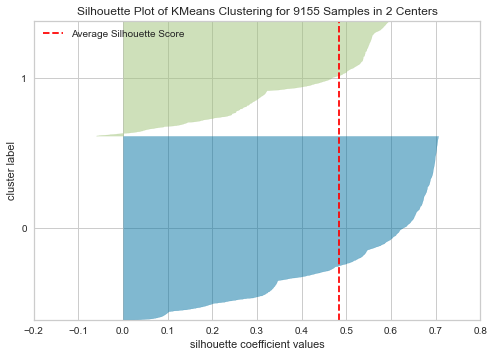

In [34]:

visualizer = SilhouetteVisualizer(estimator = kmeans_model ,colors='yellowbrick')
visualizer.fit(x)
visualizer.finalize()


In [35]:
df_mensagem = pd.merge(df_mensagem, df_contrato[['contrato_id', 'cluster', 'nome_cluster']], on='contrato_id', how='left')
df_geral = pd.merge(df_geral, df_contrato[['contrato_id', 'cluster', 'nome_cluster']], on='contrato_id', how='left')

# 6.0. Exportando para csv


In [36]:
df_contrato.to_csv('../data/dfs_cluster/df_contrato.csv', index=False)
df_mensagem.to_csv('../data/dfs_cluster/df_mensagem.csv', index=False)
df_geral.to_csv('../data/dfs_cluster/df_geral.csv', index=False)

# 7.0. DataFrame previews

## 7.1. Df_Contrato


In [37]:
df_contrato.head()

,contrato_id,nr_documento,safra,dt_contrato,dt_desembolso,dt_vencimento,dt_wo,prazo,vlr_desembolsado,vlr_tarifa,juros_mes,juros_diario,tipo_empresa,cidade,estado,...,saldo_devedor_acumulado,debito,mensagens_lidas,taxa_leitura,taxa_entregue,eficiencia,dias_de_atraso,pgto_medio,dias_restantes,ritmo_esperado,razao,dsp_atual,dspp_atual,cluster,nome_cluster
1,a5940634cbbe2a6d01d0676f6dfd6368,b0871d4e0d72afd1d44381e5b2453cb2,2020-08,2020-08-24,2020-08-26,2022-02-24,2023-02-24,30.78,59018.94,0.0,0.09588,0.00308,PF,João Pessoa,PB,...,241369.866816,183197.702650,4,0.333333,0.428571,0.000000,0,126.081135,312,587.172124,0.241008,166,290,0,desengajados
2,60a0f8d19ec695ea4f79710212cfd6dd,b0871d4e0d72afd1d44381e5b2453cb2,2021-03,2021-03-02,2021-03-04,2022-07-02,2023-07-02,27.36,25752.60,0.0,0.09588,0.00308,PF,João Pessoa,PB,...,47198.546457,41137.253408,2,0.333333,0.600000,0.000000,0,30.525178,440,93.493758,0.128421,209,209,0,desengajados
5,4207c25cdd13aba5a05ae348e889d798,9c1dc4403f8a4833bd58eea3ee85c917,2021-03,2021-03-01,2021-03-03,2022-06-01,2023-06-01,25.65,14588.01,0.0,0.04788,0.00157,PJ,Amparo,SP,...,27841.639390,16590.428501,15,0.384615,0.573529,0.466667,0,27.221044,409,40.563395,0.404115,19,130,1,engajados
6,7dfdca96b6ff0dd844e5e130aee88b30,3b6951df3075979c99a4dfd9f93efd38,2020-11,2020-10-31,2020-11-04,2022-01-31,2023-01-31,25.65,68400.00,0.0,0.04788,0.00157,PJ,Luziânia,GO,...,157336.854639,112547.608727,8,0.470588,0.566667,0.000000,78,83.867307,288,390.790308,0.284671,182,215,0,desengajados
7,a3aecc6b029cc77dd867e0e24e2d616f,9740eda3d6190add5703cd2dd280023c,2020-12,2020-12-18,2020-12-22,2022-06-18,2023-06-18,30.78,36380.25,0.0,0.04188,0.00137,PF,Santa Rita,PB,...,70476.772482,54938.767602,5,0.357143,0.700000,0.000000,0,31.941056,426,128.964243,0.220470,244,298,0,desengajados


## 7.2. Df_geral

In [38]:
df_geral.head()

,contrato_id,dt_ref_portfolio,nr_documento,status_contrato,perc_retencao,vlr_pgto_realizado,vlr_pgto_esperado,vlr_saldo_devedor,vlr_saldo_devedor_esperado,dsp,dspp,flag_transacao,qtd_transacoes,vlr_tpv,debito_sem_pagamento,valor_pago_tpv,cluster,nome_cluster
0,000180509391a5ac66ff83cae603ffb8,2020-06-15,7996daab1bbe000bb5d1cc1bf317f390,Active,0.096,0.00,27.45,6932.34,6924.81,0,0,0,0.0,0.0,6932.34,0.00000,2,bons_pagadores
1,000180509391a5ac66ff83cae603ffb8,2020-06-16,7996daab1bbe000bb5d1cc1bf317f390,Active,0.096,0.00,27.45,6952.26,6917.27,1,1,1,6.0,191.5,6952.26,0.18384,2,bons_pagadores
2,000180509391a5ac66ff83cae603ffb8,2020-06-17,7996daab1bbe000bb5d1cc1bf317f390,Active,0.096,25.43,27.45,6946.81,6909.70,0,2,1,11.0,311.5,6972.24,0.29904,2,bons_pagadores
3,000180509391a5ac66ff83cae603ffb8,2020-06-18,7996daab1bbe000bb5d1cc1bf317f390,Active,0.096,41.40,27.45,6925.38,6902.11,0,0,1,16.0,464.0,6966.78,0.44544,2,bons_pagadores
4,000180509391a5ac66ff83cae603ffb8,2020-06-19,7996daab1bbe000bb5d1cc1bf317f390,Active,0.096,61.49,27.45,6883.79,6894.50,0,0,1,18.0,595.0,6945.28,0.57120,2,bons_pagadores


## 7.3. Df_mensagem

In [39]:
df_mensagem.sample(5)


,contrato_id,dt_ref_portfolio,nr_documento,status_contrato,perc_retencao,vlr_pgto_realizado,vlr_pgto_esperado,vlr_saldo_devedor,vlr_saldo_devedor_esperado,dsp,dspp,flag_transacao,data_acao,tipo_acao,acao,status,dia,regua,eficiencia,cluster,nome_cluster
171344,7b8f7abf12f3e9758cf54a58db335bdf,2021-07-24,23cd33de0ffa70be9044e565d7b16309,Active,0.22800,0.00,48.50,17904.40,11438.21,30,115,0,2021-07-26,EMAIL,campanhaprenegativacao,ENTREGUE,30,dsp,NaN,0,desengajados
222677,9eac370c50ecefde552256b3a52a2fdd,2022-02-27,580c05e61278ff606dc7825b3819bb50,Active,1.20000,0.00,266.50,94699.99,0.00,30,160,0,2022-03-01,EMAIL,campanhaprenegativacao,NAO ENTREGUE,30,dsp,NaN,0,desengajados
177210,7f13e1ec9390606230d1d27782bf70eb,2021-06-09,0e960a565f344235551fafebf59196b7,Active,0.13956,71.63,137.32,29177.47,25285.31,0,30,1,2021-06-09,HSM,campanhaparcelamento30,ENTREGUE,30,dspp,NaN,0,desengajados
35465,18a5d45cde7cb050dd1e738b0c7dae0d,2021-05-06,6a2baea39c5db0772135f39aa133ce43,Active,0.15600,0.00,360.53,139577.47,117797.47,43,45,0,2021-05-06,EMAIL,campanhaboletoquitado45,NAO ENTREGUE,45,dspp,NaN,0,desengajados
322970,e66c1a726a7d3e5313714f116c42e4d0,2021-09-03,f74876fdddbad7701fd9eadccfe3f397,Active,0.15600,0.00,43.20,4373.31,4376.39,7,15,0,2021-09-03,HSM,campanhaobservacao15,NAO ENTREGUE,15,dspp,NaN,0,desengajados
